In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import interact widget from ipywidgets
from ipywidgets import interact
import matplotlib.ticker as ticker

np.random.seed(0)

In [2]:
# plot configurations
plt.rcParams['image.cmap'] = 'gray_r'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['image.aspect'] = 'auto'

# Set the default style
plt.style.use('ggplot')

# Set the font
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'

# Set the figure size
plt.rcParams['figure.figsize'] = [10, 6]

# Set the DPI (dots per inch)
plt.rcParams['figure.dpi'] = 100

# Set the line width
plt.rcParams['lines.linewidth'] = 2

# Set the grid
plt.rcParams['grid.color'] = '#cccccc'

# Set the axes
plt.rcParams['axes.facecolor'] = '#ffffff'
plt.rcParams['axes.edgecolor'] = '#000000'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True

# Set the legend
plt.rcParams['legend.frameon'] = False

# Set the markers
plt.rcParams['scatter.marker'] = 'o'

# Set the error bars
plt.rcParams['errorbar.capsize'] = 3

# Set the histogram bins
plt.rcParams['hist.bins'] = 'auto'
plt.rcParams['figure.autolayout'] = True

## Building the network

In [3]:
# defining the derivative of the membrane potential
def dhdt(h, I, tau, R):
    return (R * I - h) / tau
# defining the transfer function
def transfer(h, alpha, beta):
    return (1/(1 + np.exp(-2 * alpha * (h - beta))))
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
# the angle of the neuron with the maximum rate
def map_to_degree(value, N, mode='radians'):
    if mode == 'radians':
        return (value / N) * 2 * np.pi
    elif mode == 'degrees':
        return (value / N) * 360
def external_input(X, mu, sigma):
    return np.random.normal(X - mu, sigma, X.shape)

def generate_trajectory(T, dt, speed, std_dev):
    # Initialize arrays to hold the heading direction and 2D position
    theta_H = np.zeros(int(T/dt))
    position = np.zeros((int(T/dt), 2))
    # Initialize the heading direction with a random value between 0 and 2*pi
    theta_H[0] = np.random.uniform(0, 2*np.pi)
    # Loop over each time step
    for t in range(1, int(T/dt)):
        # Update the heading direction with a Gaussian random walk
        theta_H[t] = theta_H[t-1] + np.random.normal(0, std_dev)
        # Calculate the change in position based on the heading direction and speed
        delta_position = speed * dt * np.array([np.cos(theta_H[t]), np.sin(theta_H[t])])
        position[t] = position[t-1] + delta_position # Update the position

    return theta_H, position

In [4]:
def interactive_activation(alpha=.2, beta=.5):
    h_list = np.linspace(-10, 10, 1000)
    activation_list = transfer(h_list, alpha=alpha, beta=beta)

    plt.plot(h_list, activation_list, label='transfer function')
    plt.xlabel('h')
    plt.ylabel('transfer function')
    plt.legend()
    plt.show()

_ = interact(interactive_activation, alpha=(0.1, 2, 0.1), beta=(0.1, 2, 0.1))

interactive(children=(FloatSlider(value=0.2, description='alpha', max=2.0, min=0.1), FloatSlider(value=0.5, de…

## 0.1. Plot the transfer function g as a function of the potential h. How do α and β affect the shape?
- $\alpha$ is changing the slope of the transfer function, the higher the value the steeper the slope.
- $\beta$ is shifting the transfer function. The higher the value the more shifted to the right.



## 0.2 question!
We used $\omega = 1 \times 10^{-2}$ to get a reasonable oscillation. But in the question, it's $10$.
Which one is correct?

Text(0, 0.5, 'Current (A)')

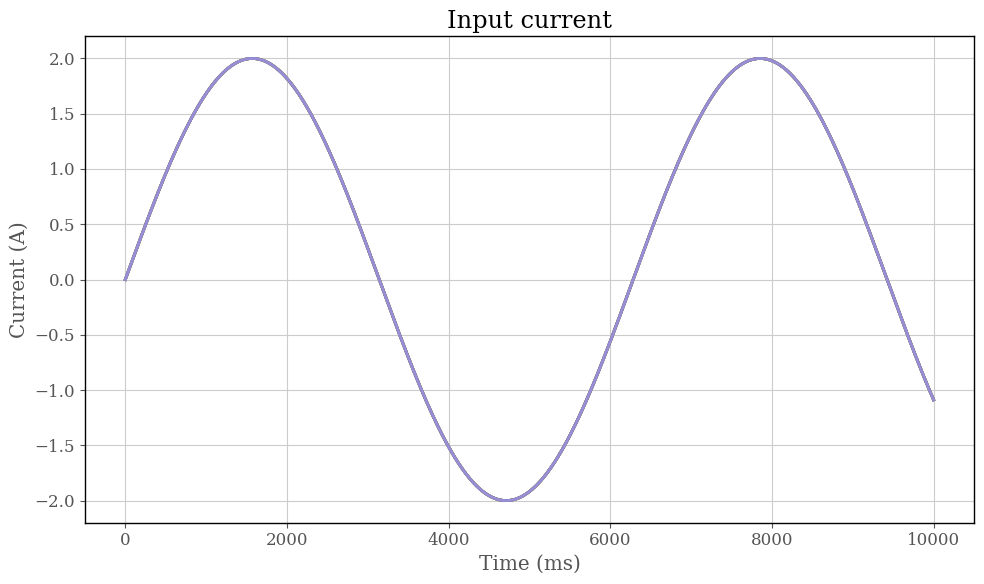

In [5]:
T = 1000 # ms
dt = .1 # ms
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 1 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

N = 10 # number of neurons
h = np.zeros((N, int(T/dt)))
t = np.linspace(0, T, int(T/dt))
I0 = 2 # 1e-6 # nA
omega = 1e-2 # Hz
# I = np.zeros((N, int(T/dt))) # input current
# I_noisy = np.random.normal(0, 1, (N, int(T/dt)))
I = I0 * np.sin(omega * np.linspace(0, T, int(T/dt)))
# repeating the input current for all neurons
I = np.tile(I, (N, 1))
# I[:,:] = I0 * np.sin(omega * t)
rate = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))
plt.plot(I.T)# + np.random.normal(0, .1, I.shape).T);
plt.title('Input current')
plt.xlabel('Time (ms)')
plt.ylabel('Current (A)')

In [6]:
for t in range(1, int(T/dt)):
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    # spikes[:, t] = np.random.poisson(rate[:, t] * dt) > 0
    # if np.random.rand() > (rate[:, t] * dt).any():
        # spikes[:, t] = 1
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    # if .any() > 0:
        # spikes[:, t] = 1
    

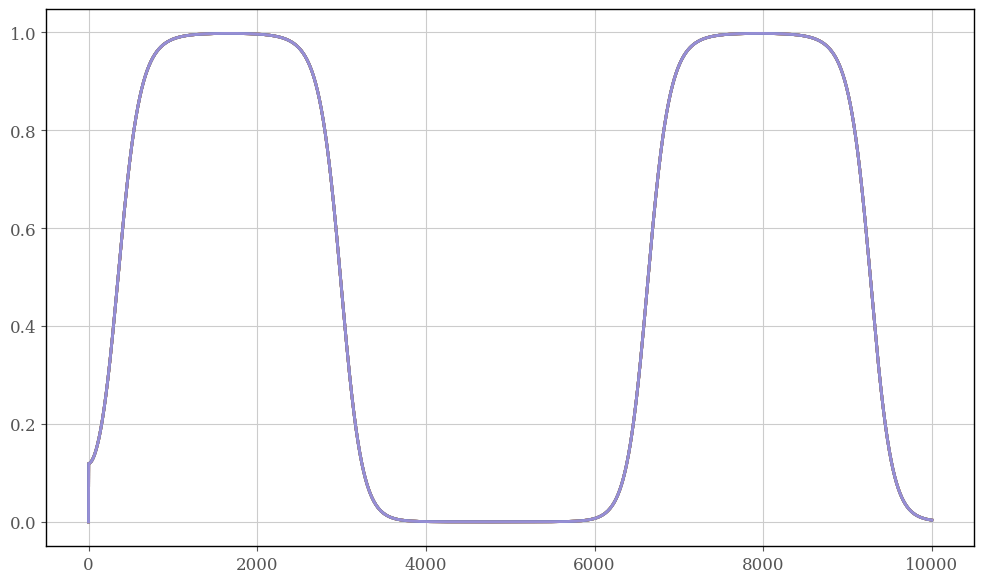

In [7]:
# plotting the rate of the neurons
for n in range(N):
    plt.plot(rate[n, :])# + np.random.normal(0, .01, rate.shape[1]), label=f'neuron {n}')

Text(0.5, 1.0, 'Spike raster')

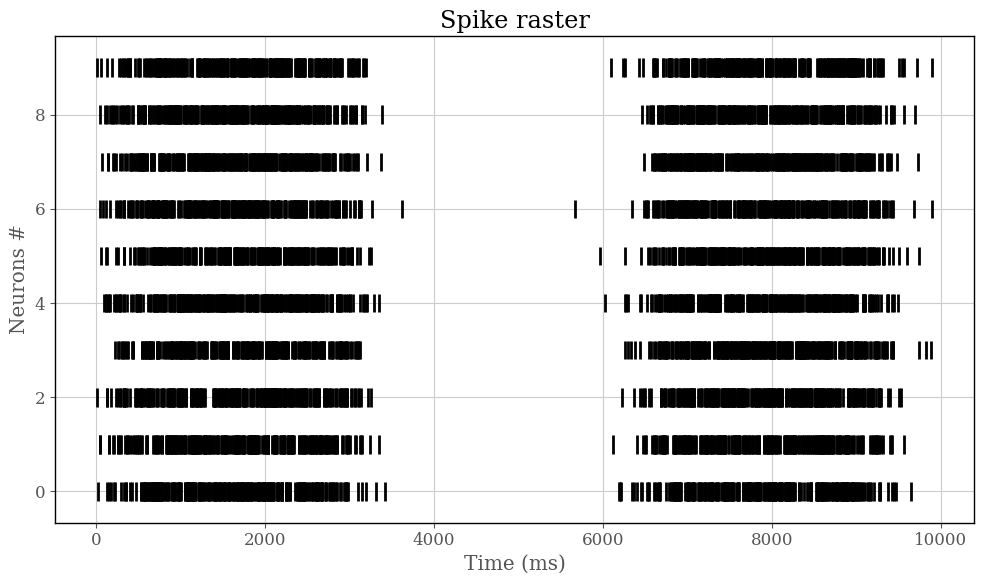

In [8]:
# plotting the spike raster
for n in range(N):
    spikes_n = np.where(spikes[n, :])[0]
    plt.vlines(spikes_n, n-.2, n+.2, color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons #')
plt.title('Spike raster')

In [9]:
def calculate_mean_rate(N, T, dt, spikes):
    # calculating the mean rate of the neurons
    mean_rate = np.zeros((N, T))
    bin_size = 10
    for t in np.arange(0, int(T/dt), bin_size):
        mean_rate[:, int(t*dt)] = np.mean(spikes[:, t:t+bin_size], axis=1)
    return mean_rate

Text(0.5, 0, 'Time (ms)')

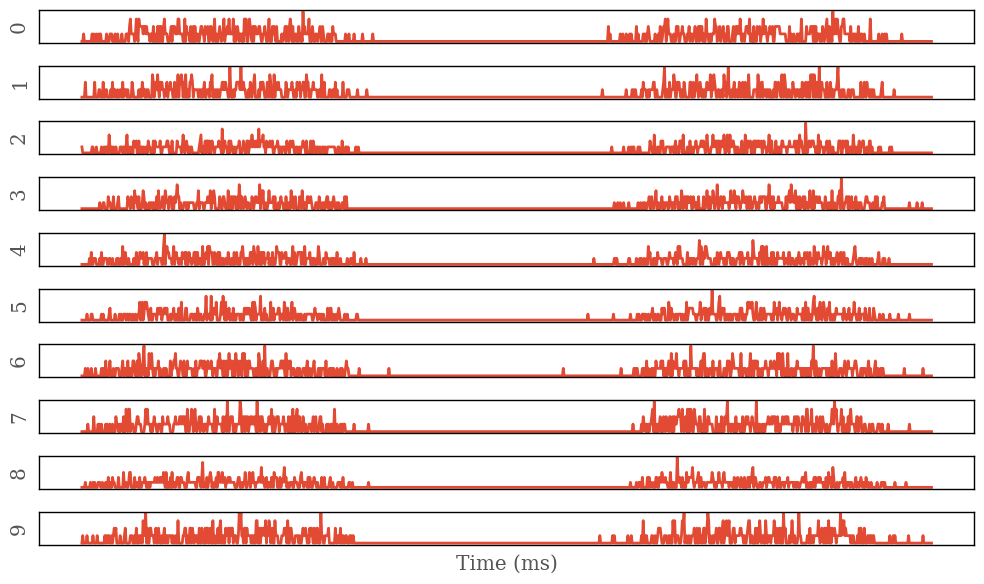

In [10]:
# calculating the mean rate of the neurons
# mean_rate = np.zeros((N, T))
# for t in np.arange(0, int(T/dt), 10):
#     mean_rate[:, int(t*dt)] = np.mean(spikes[:, t:t+10], axis=1)
mean_rate = calculate_mean_rate(N, T, dt, spikes)
# plotting the mean rate of the neurons 1 -10
plt.title('Mean rate of the neurons 1-10')
for n in range(10):
    plt.subplot(10, 1, n+1)
    plt.plot(mean_rate[n, :])
    plt.ylabel(f'{n}')
    plt.xticks([]); plt.yticks([])
plt.xlabel('Time (ms)')


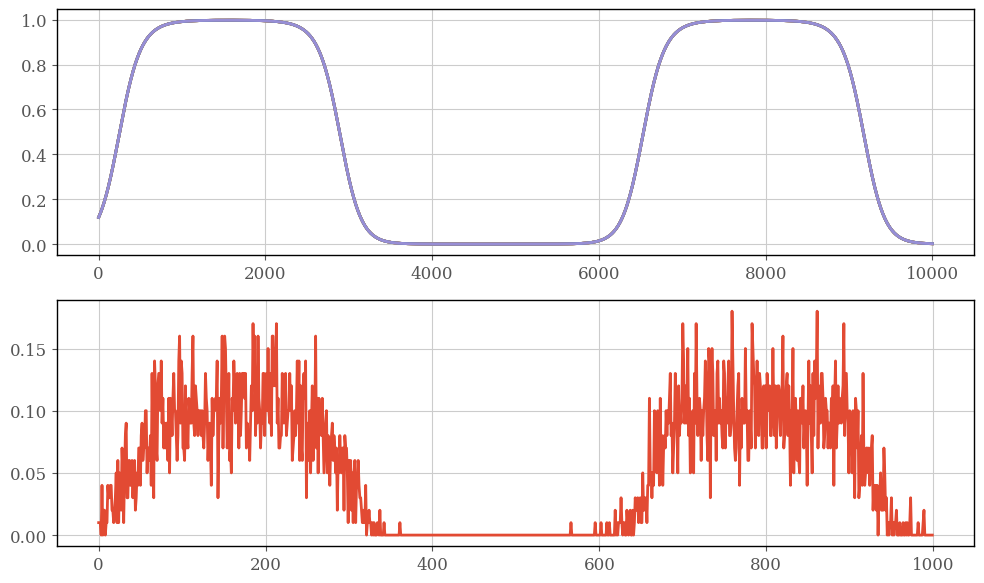

In [11]:
# comparing the theoretical rate with the mean rate of spiking neurons
theoretical_rate = r0 * transfer(R*I, alpha, beta)
plt.subplot(211)
plt.plot(theoretical_rate.T);
plt.subplot(212)
plt.plot(np.mean(mean_rate, axis=0))
# plt.plot(mean_rate[0, :])

## 0.2
- Since the spike generation is stochastic, the rate doesn't go as high as 1 (which is the maximum theoretical rate)
But it can go as high as .5 at some times.
- As long as there's no interactions between the neurons, the size of the network doesn't affect the simulation results.
- The numerical mean rate over the population tends to be smaller than the theoretical rate by a factor of 10 but it correctly follows the temporal aspects of the theoretical firing rate!

In [12]:
T = 1000 # ms
dt = .1 # ms
J = 5 # pC
N = 100
X = np.linspace(0, 2 * np.pi, N)
I = np.zeros((N, int(T/dt)))
h = np.random.uniform(0, 1, (N, int(T/dt)))
# h = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))
rate = np.zeros((N, int(T/dt)))
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 1 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

# for t in range(1, int(T/dt)):
for t in range(1, 2):
    m_cos = np.mean(np.cos(X) * spikes[:, t])
    m_sin = np.mean(np.sin(X) * spikes[:, t])
    # print(m_cos)
    I[:, t] = J/dt * (np.cos(X) * m_cos + np.sin(X) * m_sin)
    # print(I.shape)
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    

In [13]:
def interactive_activation(J = 5):
    T = 100 # ms
    dt = .1 # ms
    N = 100
    X = np.linspace(0, 2 * np.pi, N)
    I = np.zeros((N, int(T/dt)))
    h = np.random.uniform(0, 1, (N, int(T/dt)))
    tau = 10 # ms
    R = 1 # Ohm # needs to be asked on the units
    r0 = 10 # mHz
    alpha = 2 # mV^-1
    beta = .5 # mV
    # h = np.zeros((N, int(T/dt)))
    spikes = np.zeros((N, int(T/dt)))
    rate = np.zeros((N, int(T/dt)))
    m_cos = 0
    m_sin = 0

    # spikes = np.random.binomial(1, np.ones(N) * dt, (N, int(T/dt)))
    # h = np.random.normal(0, 1, (N, int(T/dt)))
    for t in range(1, int(T/dt)):
        I[:, t] = J * (np.cos(X) * m_cos + np.sin(X) * m_sin)
        h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
        rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
        spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
        m_cos = np.mean(np.cos(X) * spikes[:, t])
        m_sin = np.mean(np.sin(X) * spikes[:, t])
    
    # figure = plt.figure(figsize=(10, 5))
    plt.subplot(311)
    plt.plot(I.T, color = 'black', alpha = .1)
    plt.ylabel('Input current')
    plt.subplot(312)
    plt.plot(rate.T, color = 'red', alpha = .1)
    plt.ylabel('Rate')
    plt.subplot(313)
    # plotting the spike raster
    for n in range(N):
        spikes_n = np.where(spikes[n, :])[0]
        plt.vlines(spikes_n, n-.5e1, n+.5e1, color='black')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neurons #')
    plt.title('Spike raster')

_ = interact(interactive_activation, J=(0, 20, .1))

interactive(children=(FloatSlider(value=5.0, description='J', max=20.0), Output()), _dom_classes=('widget-inte…

## 1.1
The value $j=5 pC$ consistantly produce a bump attractor, although there are itterations for which $j=4 pC$ also shows the bump dynamics.

Text(0, 0.5, 'Rate')

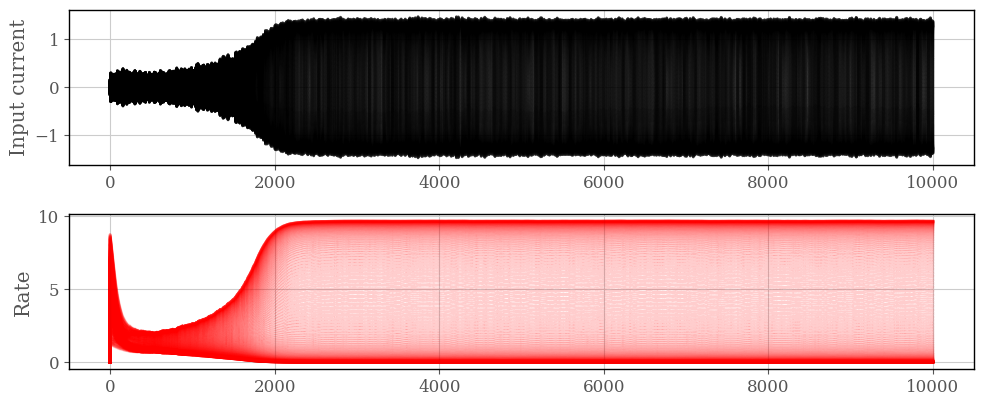

In [122]:
T = 1000 # ms
dt = .1 # ms
N = 300
X = np.linspace(0, 2 * np.pi, N)
I = np.zeros((N, int(T/dt)))
h = np.random.uniform(0, 1, (N, int(T/dt)))
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV
# h = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))
rate = np.zeros((N, int(T/dt)))
m_cos = 0
m_sin = 0

# spikes = np.random.binomial(1, np.ones(N) * dt, (N, int(T/dt)))
# h = np.random.normal(0, 1, (N, int(T/dt)))
for t in range(1, int(T/dt)):
    I[:, t] = J * (np.cos(X) * m_cos + np.sin(X) * m_sin)
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    m_cos = np.mean(np.cos(X) * spikes[:, t])
    m_sin = np.mean(np.sin(X) * spikes[:, t])

# figure = plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.plot(I.T, color = 'black', alpha = .1)
plt.ylabel('Input current')
plt.subplot(312)
plt.plot(rate.T, color = 'red', alpha = .1)
plt.ylabel('Rate')
# plt.subplot(313)
# # plotting the spike raster
# for n in range(N):
#     spikes_n = np.where(spikes[n, :])[0]
#     plt.vlines(spikes_n, n-.5e1, n+.5e1, color='black')
# plt.xlabel('Time (ms)')
# plt.ylabel('Neurons #')
# plt.title('Spike raster')

# 1.2
The location of the bump becomes stable after a while.

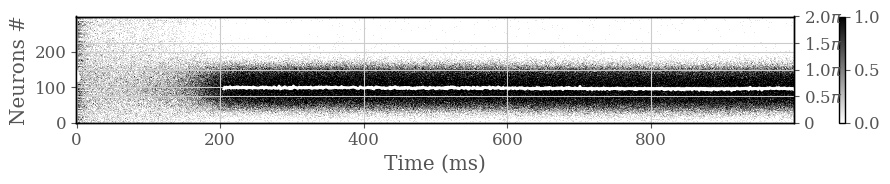

In [137]:
mean_rate = calculate_mean_rate(N, T, dt, spikes)
mean_over_time = np.mean(mean_rate, axis=1)
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
im = ax.imshow(mean_rate, aspect='auto', origin='lower')
plt.colorbar(im)
ax.set_ylabel('Neurons #')
ax.set_xlabel('Time (ms)')
max_neuron_rate = []
for t in range(1, T):
    if np.sum(mean_rate[:, t], axis=0) < 2*N/3 and np.sum(mean_rate[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
        top_neurons = np.argpartition(mean_rate[:, t], -100)[-100:]
        max_neuron_rate.append(np.mean(top_neurons))
    else:
        max_neuron_rate.append(np.nan)
# mean_over_neurons = np.mean(mean_rate, axis=0)
ax1 = ax.twinx()
max_neuron_rate = np.array(max_neuron_rate)
max_angle = map_to_degree(max_neuron_rate, N)
ax1.plot(max_angle, color='white')
# ax1.set_ylim(0, 360)
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0'))

# ax1.set_ylabel('Angle (degrees)')
# 

# 1.3
The larger the N the more the more drift we saw.
The $\tau$ and $dt$ are making the dynamic faster and quicker to evolve. If there's a drift present in the dynamic, larger $\tau$ and $dt$ will show pronounce it. Basically, larger $\tau$ and larger $dt$ will make the system approach faster to their stable behavior (fixed points).

# 1.4

Text(0.5, 1.0, 'Spike raster')

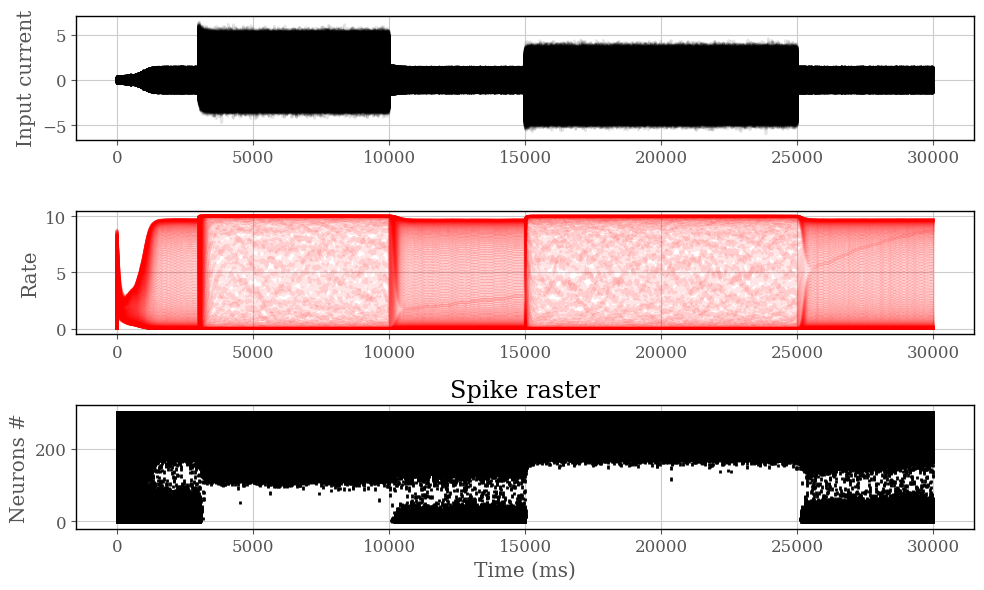

In [140]:
T = 3000 # ms
dt = .1 # ms
N = 300
X = np.linspace(0, 2 * np.pi, N)
I = np.zeros((N, int(T/dt)))

h = np.random.uniform(0, 1, (N, int(T/dt)))
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV
# h = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))
rate = np.zeros((N, int(T/dt)))
m_cos = 0
m_sin = 0

# spikes = np.random.binomial(1, np.ones(N) * dt, (N, int(T/dt)))
# h = np.random.normal(0, 1, (N, int(T/dt)))
for t in range(1, int(T/dt)):
    if t >= int(300/dt) and t < int(1000/dt):
        external_input_at_t = external_input(X, 2 * np.pi / 3, np.pi/8)
    elif t >= int(1500/dt) and t < int(2500/dt):
        external_input_at_t = external_input(X, 4 * np.pi / 3, np.pi/8)
    else:
        external_input_at_t = np.zeros(N)
    I[:, t] = J * (np.cos(X) * m_cos + np.sin(X) * m_sin) + external_input_at_t
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    m_cos = np.mean(np.cos(X) * spikes[:, t])
    m_sin = np.mean(np.sin(X) * spikes[:, t])

# figure = plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.plot(I.T, color = 'black', alpha = .1)
plt.ylabel('Input current')
plt.subplot(312)
plt.plot(rate.T, color = 'red', alpha = .1)
plt.ylabel('Rate')
plt.subplot(313)
# plotting the spike raster
for n in range(N):
    spikes_n = np.where(spikes[n, :])[0]
    plt.vlines(spikes_n, n-.5e1, n+.5e1, color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons #')
plt.title('Spike raster')

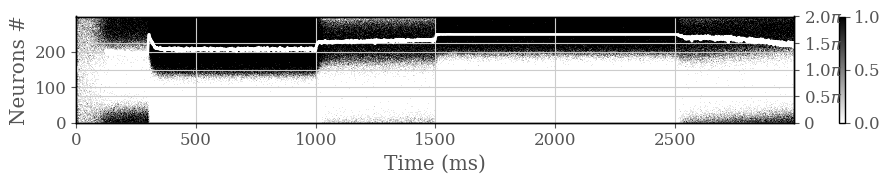

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
mean_rate = calculate_mean_rate(N, T, dt, spikes)
mean_over_time = np.mean(mean_rate, axis=1)
im = ax.imshow(mean_rate, aspect='auto', origin='lower')
ax.set_ylabel('Neurons #')
ax.set_xlabel('Time (ms)')
plt.colorbar(im)
max_neuron_rate = []
for t in range(1, T):
    # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    if np.sum(mean_rate[:, t], axis=0) < 2*N/3 and np.sum(mean_rate[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
        top_neurons = np.argpartition(mean_rate[:, t], -100)[-100:]
        max_neuron_rate.append(np.mean(top_neurons))
    else:
        max_neuron_rate.append(np.nan)
# mean_over_neurons = np.mean(mean_rate, axis=0)
# plt.plot(max_neuron_rate, color='white')
ax1 = ax.twinx()
max_neuron_rate = np.array(max_neuron_rate)
max_angle = map_to_degree(max_neuron_rate, N)
ax1.plot(max_angle, color='white')
# ax1.set_ylim(0, 360)
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0'))

# ax1.set_ylabel('Angle (degrees)')
# 


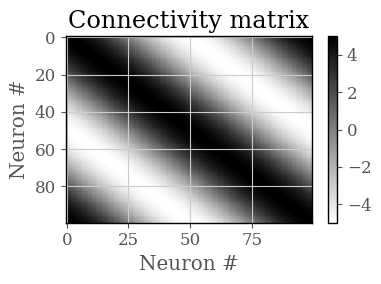

In [14]:
# Paramètres du réseau
# Fonction de connectivité
plt.figure(figsize=(4, 3))
def connectivity_profile(xi, xj):
    return J * np.cos(xi - xj)

# Création de la matrice de connectivité
connectivity_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        connectivity_matrix[i, j] = connectivity_profile(X[i], X[j])

# Affichage de la matrice de connectivité
plt.imshow(connectivity_matrix)
plt.ylabel('Neuron #')
plt.xlabel('Neuron #')
plt.title('Connectivity matrix')
plt.colorbar()

# 1.4
The connectivity matrix will tells us how neurons interact with each other. Neurons that have distance equal to $|X_i - X_j| = \pi/2$ doesn't interact with each other as $w(x_i,x_j)=\cos(\pi/2)=0$ while other neurons with distance of $\pi$ can inhibit each other as $\cos(\pi)=-1$.
So giving an external input which only activates a subgroup of neurons will lead the neurons to talk to each other based on their connectivity matrix. So these active neurons due to external input will silent those neurons that have distance of equal $\pi$ while exhibit those who have of distance $0$ and doesn't do anything to those with distance $\pi/2$.
The external inputs will drive the network towards the mean angle $\mu$ and then the internal interactions do its job which is exciting and inhibting other neurons that are encoding other angles.


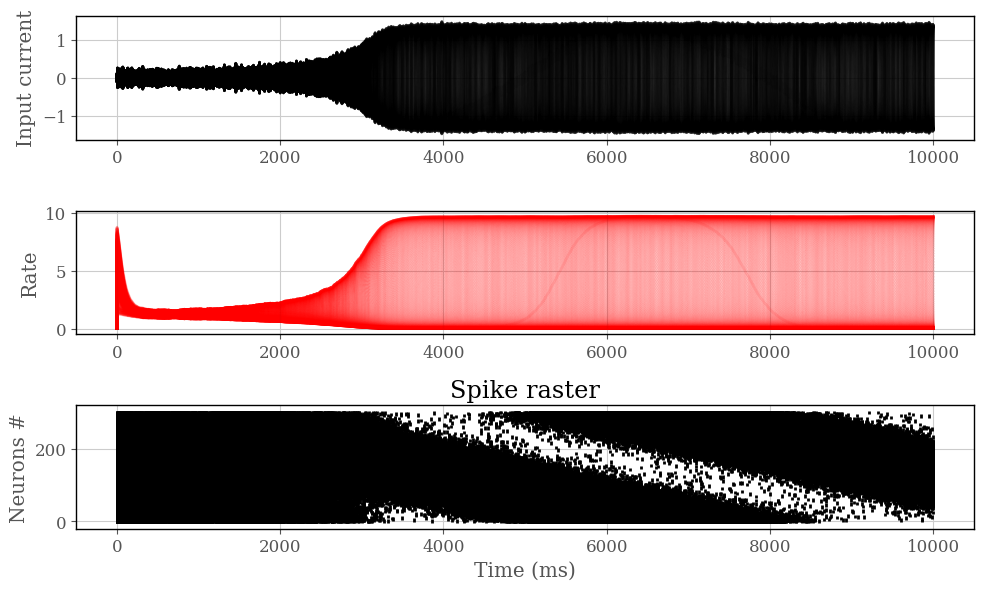

In [15]:
T = 1000 # ms
dt = .1 # ms
N = 300
X = np.linspace(0, 2 * np.pi, N)
X1 = np.linspace(0, 2 * np.pi, N) + np.pi/30
I = np.zeros((N, int(T/dt)))
h = np.random.uniform(0, 1, (N, int(T/dt)))
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV
# h = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))
rate = np.zeros((N, int(T/dt)))
m_cos = 0
m_sin = 0

# spikes = np.random.binomial(1, np.ones(N) * dt, (N, int(T/dt)))
# h = np.random.normal(0, 1, (N, int(T/dt)))
for t in range(1, int(T/dt)):
    I[:, t] = J * (np.cos(X1) * m_cos + np.sin(X1) * m_sin)
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    m_cos = np.mean(np.cos(X) * spikes[:, t])
    m_sin = np.mean(np.sin(X) * spikes[:, t])

# figure = plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.plot(I.T, color = 'black', alpha = .1)
plt.ylabel('Input current')
plt.subplot(312)
plt.plot(rate.T, color = 'red', alpha = .1)
plt.ylabel('Rate')
plt.subplot(313)
# plotting the spike raster
for n in range(N):
    spikes_n = np.where(spikes[n, :])[0]
    plt.vlines(spikes_n, n-.5e1, n+.5e1, color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons #')
plt.title('Spike raster')
plt.tight_layout()

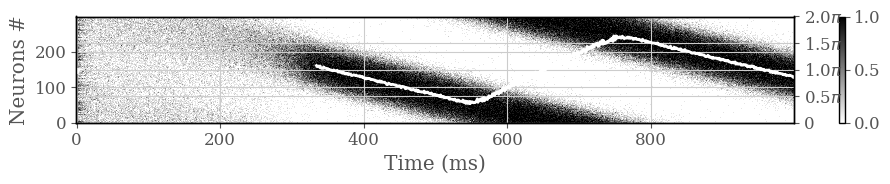

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
mean_rate = calculate_mean_rate(N, T, dt, spikes)
mean_over_time = np.mean(mean_rate, axis=1)
im = ax.imshow(mean_rate, aspect='auto', origin='lower')
ax.set_ylabel('Neurons #')
ax.set_xlabel('Time (ms)')
plt.colorbar(im)
max_neuron_rate = []
for t in range(1, T):
    # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    if np.sum(mean_rate[:, t], axis=0) < 2*N/3 and np.sum(mean_rate[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
        top_neurons = np.argpartition(mean_rate[:, t], -100)[-100:]
        max_neuron_rate.append(np.mean(top_neurons))
    else:
        max_neuron_rate.append(np.nan)
# mean_over_neurons = np.mean(mean_rate, axis=0)
# plt.plot(max_neuron_rate, color='white')
ax1 = ax.twinx()
max_neuron_rate = np.array(max_neuron_rate)
max_angle = map_to_degree(max_neuron_rate, N)
ax1.plot(max_angle, color='white')
# ax1.set_ylim(0, 360)
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 


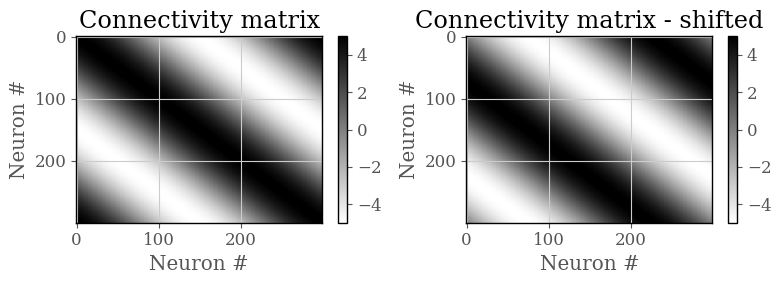

In [17]:
# Paramètres du réseau
# Fonction de connectivité
plt.figure(figsize=(8, 3))
plt.subplot(121)
def connectivity_profile(xi, xj):
    return J * np.cos(xi - xj)

# Création de la matrice de connectivité
connectivity_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        connectivity_matrix[i, j] = connectivity_profile(X[i], X[j])

# Affichage de la matrice de connectivité
plt.imshow(connectivity_matrix)
plt.ylabel('Neuron #')
plt.xlabel('Neuron #')
plt.title('Connectivity matrix')
plt.colorbar()

plt.subplot(122)
# calculating the connectivity matrix 
connectivity_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        connectivity_matrix[i, j] = connectivity_profile(X[i] - np.pi/2, X[j])

# plotting the connectivity matrix
plt.imshow(connectivity_matrix)
plt.ylabel('Neuron #')
plt.xlabel('Neuron #')
plt.title('Connectivity matrix - shifted')
plt.colorbar()

# 1.5 
Adding this small shift in angle in the connectivity matrix will cause a non-symmetric connection profile for each neuron. This time each neuron has stronger connection between one side neighbours compare to the other side.
This effectively means that each neuron's connectivity profile is slightly shifted by the angle $\phi$. The effect of this shift is to introduce a preferred direction of motion for the bump, causing it to drift.
The bump of activity will no longer remain stationary.The bump will drift in the direction corresponding to the sign of $\phi$. This drift occurs because the neurons are now more strongly connected to their neighbors in one direction, creating an imbalance that causes the bump to move periodically.


# Exercise 2
# 2.1
The input that each neuron in $L$ population receives is:
$$
I_i^L = \frac{J^L}{N} \sum_{j=1}^{N^L} w_{L \rightarrow L}(x_i^L, x_j^L) S_j^L(t) 
 + \frac{J^R}{N} \sum_{j=1}^{N^R} w_{R \rightarrow L}(x_i^R, x_j^R) S_j^R(t)
$$
and the input that each neuron in $R$ population receives is:
$$
I_i^R = \frac{J^R}{N} \sum_{j=1}^{N^R} w_{R \rightarrow R}(x_i^R, x_j^R) S_j^R(t)
+ \frac{J^L}{N} \sum_{j=1}^{N^L} w_{L \rightarrow R}(x_i^L, x_j^L) S_j^L(t) 
$$

We can explain this mechanism by examining the connectivity weights between populations. Connectivity weights are defined by cosine functions with a shift $θ$, meaning that when activity is maximal in one population, it is minimal in the other. For example, if the activity bump moves to the right in the left population, this inhibits the corresponding part of the right population, keeping the total input in the linear regime.

In a stable configuration, the activity bump is held in place by this dynamic equilibrium. If the bump starts to move in one direction, the push-pull system is activated to stabilize it. For example, if the bump moves to the right in the left population, this increases activity in the right part of that population. However, due to connectivity weights, this inhibits the left part of the right population, pushing the bump in this population to the left. This process balances out, preventing the bump from moving indefinitely and thus maintaining a stable configuration.




# 2.2
The bump will be stable after a short time and will remain stable for the rest of the simulation.
There's no drift since the same $\theta$ shift applied for both right and left populations.

In [21]:
# global parameters
T = 600 # ms
dt = .1 # ms
N = 300
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

# parameters for the left and right populations
Xl = np.linspace(0, 2 * np.pi, N)
Xr = np.linspace(0, 2 * np.pi, N)
theta_l = 10 * np.pi / 180
theta_r = 10 * np.pi / 180
Il = np.zeros((N, int(T/dt)))
Ir = np.zeros((N, int(T/dt)))
hl = np.random.uniform(0, 1, (N, int(T/dt)))
hr = np.random.uniform(0, 1, (N, int(T/dt)))
spikes_l = np.zeros((N, int(T/dt)))
spikes_r = np.zeros((N, int(T/dt)))
rate_l = np.zeros((N, int(T/dt)))
rate_r = np.zeros((N, int(T/dt)))
m_cos_l = 0
m_cos_r = 0
m_sin_l = 0
m_sin_r = 0
Jl = 3
Jr = 3
# initial conditions for h such that the center of the bump remains around pi
# creating initial values for the neurons such that the centering neuron has the highest rate
peak_index = 150
std_dev = 50
indices = np.arange(N)
# simulation of both populations
for t in range(1, int(T/dt)):
    Il[:, t] = Jl * (np.cos(Xl+theta_l) * m_cos_l + np.sin(Xl+theta_l) * m_sin_l) + Jr * (np.cos(Xl+theta_l) * m_cos_r + np.sin(Xl+theta_l) * m_sin_r)
    Ir[:, t] = Jr * (np.cos(Xr-theta_r) * m_cos_r + np.sin(Xr-theta_r) * m_sin_r) + Jl * (np.cos(Xr-theta_r) * m_cos_l + np.sin(Xr-theta_r) * m_sin_l)

    hl[:, t] = hl[:, t-1] + dt * dhdt(hl[:, t-1], Il[:, t-1], tau, R)
    hr[:, t] = hr[:, t-1] + dt * dhdt(hr[:, t-1], Ir[:, t-1], tau, R)
    
    rate_l[:, t] = r0 * transfer(hl[:, t], alpha, beta)
    rate_r[:, t] = r0 * transfer(hr[:, t], alpha, beta)
    
    spikes_l[:, t] = np.random.binomial(1, rate_l[:, t] * dt)
    spikes_r[:, t] = np.random.binomial(1, rate_r[:, t] * dt)
    
    m_cos_l = np.mean(np.cos(Xl) * spikes_l[:, t])
    m_cos_r = np.mean(np.cos(Xr) * spikes_r[:, t])
    
    m_sin_l = np.mean(np.sin(Xl) * spikes_l[:, t])
    m_sin_r = np.mean(np.sin(Xr) * spikes_r[:, t])

# figure = plt.figure(figsize=(10, 10))
# plt.subplot(611)
# plt.plot(Il.T, color = 'red', alpha = .1)
# plt.ylabel('Input current L')
# plt.subplot(612)
# plt.plot(rate_l.T, color = 'red', alpha = .1)
# plt.ylabel('Rate L')
# plt.subplot(613)
# # plotting the spike raster
# for n in range(N):
#     spikes_n = np.where(spikes_l[n, :])[0]
#     plt.vlines(spikes_n, n-.5e1, n+.5e1, color='red')
# plt.xlabel('Time (ms)')
# plt.ylabel('Neurons # L')
# plt.title('Spike raster L')

# plt.subplot(614)
# plt.plot(Ir.T, color = 'blue', alpha = .1)
# plt.ylabel('Input current R')
# plt.subplot(615)
# plt.plot(rate_r.T, color = 'blue', alpha = .1)
# plt.ylabel('Rate R')
# plt.subplot(616)
# # plotting the spike raster
# for n in range(N):
#     spikes_n = np.where(spikes_r[n, :])[0]
#     plt.vlines(spikes_n, n-.5e1, n+.5e1, color='blue')
# plt.xlabel('Time (ms)')
# plt.ylabel('Neurons # R')
# plt.title('Spike raster')

/var/folders/m8/zm1w89m57wq8zmk8vcljy8ym0000gp/T/ipykernel_24699/3307979539.py:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)
/var/folders/m8/zm1w89m57wq8zmk8vcljy8ym0000gp/T/ipykernel_24699/3307979539.py:34: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)


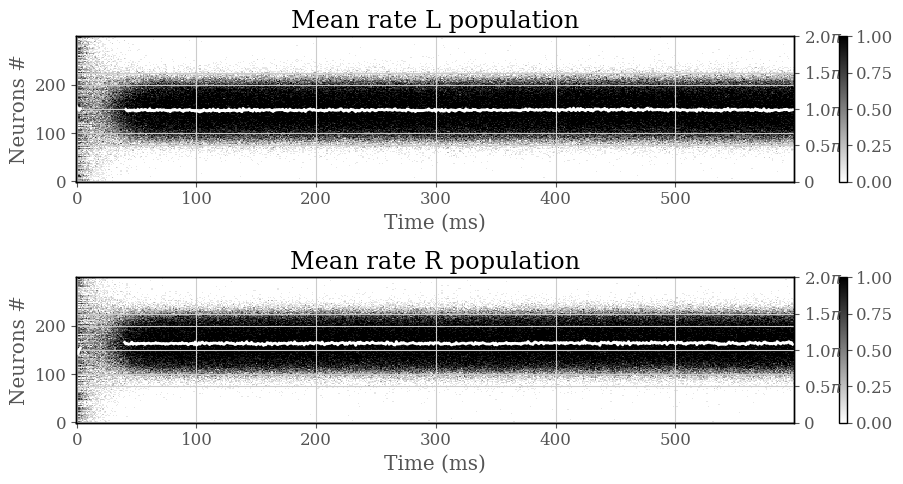

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
mean_rate_l = calculate_mean_rate(N, T, dt, spikes_l)
mean_over_time_l = np.mean(mean_rate_l, axis=1)
im = ax[0].imshow(mean_rate_l, aspect='auto', origin='lower')
ax[0].set_ylabel('Neurons #')
ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Mean rate L population')
plt.colorbar(im)
max_neuron_rate_l = []
for t in range(1, T):
    # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    if np.sum(mean_rate_l[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_l[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
        top_neurons_l = np.argpartition(mean_rate_l[:, t], -100)[-100:]
        max_neuron_rate_l.append(np.mean(top_neurons_l))
    else:
        max_neuron_rate_l.append(np.nan)
# mean_over_neurons = np.mean(mean_rate, axis=0)
# plt.plot(max_neuron_rate, color='white')
ax1 = ax[0].twinx()
max_neuron_rate_l = np.array(max_neuron_rate_l)
max_angle_l = map_to_degree(max_neuron_rate_l, N)
ax1.plot(max_angle_l, color='white')
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 

mean_rate_r = calculate_mean_rate(N, T, dt, spikes_r)
mean_over_time_r = np.mean(mean_rate_r, axis=1)
im = ax[1].imshow(mean_rate_r, aspect='auto', origin='lower')
ax[1].set_ylabel('Neurons #')
ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Mean rate R population')
plt.colorbar(im)
max_neuron_rate_r = []
for t in range(1, T):
    # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    if np.sum(mean_rate_r[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_r[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
        top_neurons_r = np.argpartition(mean_rate_r[:, t], -100)[-100:]
        max_neuron_rate_r.append(np.mean(top_neurons_r))
    else:
        max_neuron_rate_r.append(np.nan)
# mean_over_neurons = np.mean(mean_rate, axis=0)
# plt.plot(max_neuron_rate, color='white')
ax1 = ax[1].twinx()
max_neuron_rate_r = np.array(max_neuron_rate_r)
max_angle_r = map_to_degree(max_neuron_rate_r, N)
ax1.plot(max_angle_r, color='white')
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 


# 2.3
To stablize the center of the two bumps at $\pi$ we initialzed the membrane potential of each neuron such that the neurons corresponding the angle $\pi$ has the maximum value of 1 by pushing a normal distribution around those neurons. The both ends of neurons therefore has small values (~ 0). This ensures that the center of the bump remains around $\pi$.

In [23]:
# global parameters
T = 600 # ms
dt = .1 # ms
N = 300
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

# parameters for the left and right populations
Xl = np.linspace(0, 2 * np.pi, N)
Xr = np.linspace(0, 2 * np.pi, N)
theta_l = 10 * np.pi / 180
theta_r = 10 * np.pi / 180
Il = np.zeros((N, int(T/dt)))
Ir = np.zeros((N, int(T/dt)))
hl = np.random.uniform(0, 1, (N, int(T/dt)))
hr = np.random.uniform(0, 1, (N, int(T/dt)))
spikes_l = np.zeros((N, int(T/dt)))
spikes_r = np.zeros((N, int(T/dt)))
rate_l = np.zeros((N, int(T/dt)))
rate_r = np.zeros((N, int(T/dt)))
m_cos_l = 0
m_cos_r = 0
m_sin_l = 0
m_sin_r = 0
Jl = 3
Jr = 3
# initial conditions for h such that the center of the bump remains around pi
# creating initial values for the neurons such that the centering neuron has the highest rate
peak_index = 150
std_dev = 50
indices = np.arange(N)
normal_dist = np.exp(-((indices - peak_index) ** 2) / (2 * std_dev ** 2))
initial_array = normal_dist * np.random.normal(0, .3, N)
initial_array = np.abs(initial_array)

hl[:, 0] = initial_array
hr[:, 0] = initial_array
# simulation of both populations
for t in range(1, int(T/dt)):
    Il[:, t] = Jl * (np.cos(Xl+theta_l) * m_cos_l + np.sin(Xl+theta_l) * m_sin_l) + Jr * (np.cos(Xl+theta_l) * m_cos_r + np.sin(Xl+theta_l) * m_sin_r)
    Ir[:, t] = Jr * (np.cos(Xr-theta_r) * m_cos_r + np.sin(Xr-theta_r) * m_sin_r) + Jl * (np.cos(Xr-theta_r) * m_cos_l + np.sin(Xr-theta_r) * m_sin_l)

    hl[:, t] = hl[:, t-1] + dt * dhdt(hl[:, t-1], Il[:, t-1], tau, R)
    hr[:, t] = hr[:, t-1] + dt * dhdt(hr[:, t-1], Ir[:, t-1], tau, R)
    
    rate_l[:, t] = r0 * transfer(hl[:, t], alpha, beta)
    rate_r[:, t] = r0 * transfer(hr[:, t], alpha, beta)
    
    spikes_l[:, t] = np.random.binomial(1, rate_l[:, t] * dt)
    spikes_r[:, t] = np.random.binomial(1, rate_r[:, t] * dt)
    
    m_cos_l = np.mean(np.cos(Xl) * spikes_l[:, t])
    m_cos_r = np.mean(np.cos(Xr) * spikes_r[:, t])
    
    m_sin_l = np.mean(np.sin(Xl) * spikes_l[:, t])
    m_sin_r = np.mean(np.sin(Xr) * spikes_r[:, t])

# figure = plt.figure(figsize=(10, 10))
# plt.subplot(611)
# plt.plot(Il.T, color = 'red', alpha = .1)
# plt.ylabel('Input current L')
# plt.subplot(612)
# plt.plot(rate_l.T, color = 'red', alpha = .1)
# plt.ylabel('Rate L')
# plt.subplot(613)
# # plotting the spike raster
# for n in range(N):
#     spikes_n = np.where(spikes_l[n, :])[0]
#     plt.vlines(spikes_n, n-.5e1, n+.5e1, color='red')
# plt.xlabel('Time (ms)')
# plt.ylabel('Neurons # L')
# plt.title('Spike raster L')

# plt.subplot(614)
# plt.plot(Ir.T, color = 'blue', alpha = .1)
# plt.ylabel('Input current R')
# plt.subplot(615)
# plt.plot(rate_r.T, color = 'blue', alpha = .1)
# plt.ylabel('Rate R')
# plt.subplot(616)
# # plotting the spike raster
# for n in range(N):
#     spikes_n = np.where(spikes_r[n, :])[0]
#     plt.vlines(spikes_n, n-.5e1, n+.5e1, color='blue')
# plt.xlabel('Time (ms)')
# plt.ylabel('Neurons # R')
# plt.title('Spike raster')

/var/folders/m8/zm1w89m57wq8zmk8vcljy8ym0000gp/T/ipykernel_24699/3307979539.py:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)
/var/folders/m8/zm1w89m57wq8zmk8vcljy8ym0000gp/T/ipykernel_24699/3307979539.py:34: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)


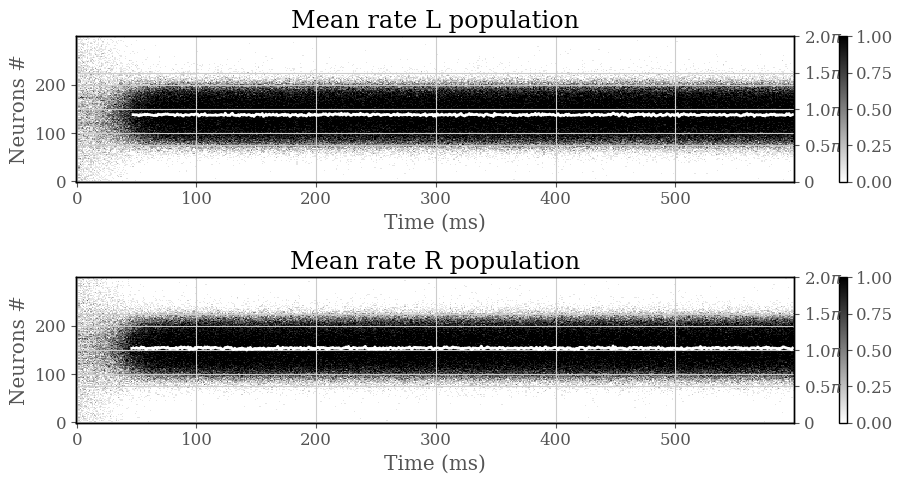

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
mean_rate_l = calculate_mean_rate(N, T, dt, spikes_l)
mean_over_time_l = np.mean(mean_rate_l, axis=1)
im = ax[0].imshow(mean_rate_l, aspect='auto', origin='lower')
ax[0].set_ylabel('Neurons #')
ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Mean rate L population')
plt.colorbar(im)
max_neuron_rate_l = []
for t in range(1, T):
    # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    if np.sum(mean_rate_l[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_l[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
        top_neurons_l = np.argpartition(mean_rate_l[:, t], -100)[-100:]
        max_neuron_rate_l.append(np.mean(top_neurons_l))
    else:
        max_neuron_rate_l.append(np.nan)
# mean_over_neurons = np.mean(mean_rate, axis=0)
# plt.plot(max_neuron_rate, color='white')
ax1 = ax[0].twinx()
max_neuron_rate_l = np.array(max_neuron_rate_l)
max_angle_l = map_to_degree(max_neuron_rate_l, N)
ax1.plot(max_angle_l, color='white')
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 

mean_rate_r = calculate_mean_rate(N, T, dt, spikes_r)
mean_over_time_r = np.mean(mean_rate_r, axis=1)
im = ax[1].imshow(mean_rate_r, aspect='auto', origin='lower')
ax[1].set_ylabel('Neurons #')
ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Mean rate R population')
plt.colorbar(im)
max_neuron_rate_r = []
for t in range(1, T):
    # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    if np.sum(mean_rate_r[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_r[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
        top_neurons_r = np.argpartition(mean_rate_r[:, t], -100)[-100:]
        max_neuron_rate_r.append(np.mean(top_neurons_r))
    else:
        max_neuron_rate_r.append(np.nan)
# mean_over_neurons = np.mean(mean_rate, axis=0)
# plt.plot(max_neuron_rate, color='white')
ax1 = ax[1].twinx()
max_neuron_rate_r = np.array(max_neuron_rate_r)
max_angle_r = map_to_degree(max_neuron_rate_r, N)
ax1.plot(max_angle_r, color='white')
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 


# 2.4

For strong values of external input (~ $\pm 1.5$) the bump will disappear. This disapearing of bump will be different for each population as for one population all of the neurons become active and for the other population all of the neurons become inactive. But for both populations, there's no significant difference between the activity of neurons within the population (therefore, no bump).
Once the external input goes away $(t > 600 ms)$ the two network has the chance to reconfigure their bumps. But this time, since there's no strong initialization the bump will be at a random position.

In [72]:
# Cheking only for 1 itteration
# global parameters
T = 10000 # ms
dt = .1 # ms
N = 300
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

# parameters for the left and right populations
Xl = np.linspace(0, 2 * np.pi, N)
Xr = np.linspace(0, 2 * np.pi, N)
theta_l = 10 * np.pi / 180
theta_r = 10 * np.pi / 180
Il = np.zeros((N, int(T/dt)))
Ir = np.zeros((N, int(T/dt)))
hl = np.random.uniform(0, 1, (N, int(T/dt)))
hr = np.random.uniform(0, 1, (N, int(T/dt)))
spikes_l = np.zeros((N, int(T/dt)))
spikes_r = np.zeros((N, int(T/dt)))
rate_l = np.zeros((N, int(T/dt)))
rate_r = np.zeros((N, int(T/dt)))
m_cos_l = 0
m_cos_r = 0
m_sin_l = 0
m_sin_r = 0
Jl = 3
Jr = 3
# initial conditions for h such that the center of the bump remains around pi
# creating initial values for the neurons such that the centering neuron has the highest rate
peak_index = 150
std_dev = 50
indices = np.arange(N)
normal_dist = np.exp(-((indices - peak_index) ** 2) / (2 * std_dev ** 2))
initial_array = normal_dist * np.random.normal(0, .3, N)
initial_array = np.abs(initial_array)

hl[:, 0] = initial_array
hr[:, 0] = initial_array

I0 = -.3
# simulation of both populations
for t in range(1, int(T/dt)):
    Il[:, t] = Jl * (np.cos(Xl+theta_l) * m_cos_l + np.sin(Xl+theta_l) * m_sin_l) + Jr * (np.cos(Xl+theta_l) * m_cos_r + np.sin(Xl+theta_l) * m_sin_r)
    Ir[:, t] = Jr * (np.cos(Xr-theta_r) * m_cos_r + np.sin(Xr-theta_r) * m_sin_r) + Jl * (np.cos(Xr-theta_r) * m_cos_l + np.sin(Xr-theta_r) * m_sin_l)
    
    # if t >= int(300/dt) and t < int(600/dt):
    Il[:, t] = Il[:, t] - I0
    Ir[:, t] = Ir[:, t] + I0

    hl[:, t] = hl[:, t-1] + dt * dhdt(hl[:, t-1], Il[:, t-1], tau, R)
    hr[:, t] = hr[:, t-1] + dt * dhdt(hr[:, t-1], Ir[:, t-1], tau, R)
    
    rate_l[:, t] = r0 * transfer(hl[:, t], alpha, beta)
    rate_r[:, t] = r0 * transfer(hr[:, t], alpha, beta)
    
    spikes_l[:, t] = np.random.binomial(1, rate_l[:, t] * dt)
    spikes_r[:, t] = np.random.binomial(1, rate_r[:, t] * dt)
    
    m_cos_l = np.mean(np.cos(Xl) * spikes_l[:, t])
    m_cos_r = np.mean(np.cos(Xr) * spikes_r[:, t])
    
    m_sin_l = np.mean(np.sin(Xl) * spikes_l[:, t])
    m_sin_r = np.mean(np.sin(Xr) * spikes_r[:, t])

# figure = plt.figure(figsize=(10, 10))
# plt.subplot(611)
# plt.plot(Il.T, color = 'red', alpha = .1)
# plt.ylabel('Input current L')
# plt.subplot(612)
# plt.plot(rate_l.T, color = 'red', alpha = .1)
# plt.ylabel('Rate L')
# plt.subplot(613)
# # plotting the spike raster
# for n in range(N):
#     spikes_n = np.where(spikes_l[n, :])[0]
#     plt.vlines(spikes_n, n-.5e1, n+.5e1, color='red')
# plt.xlabel('Time (ms)')
# plt.ylabel('Neurons # L')
# plt.title('Spike raster L')

# plt.subplot(614)
# plt.plot(Ir.T, color = 'blue', alpha = .1)
# plt.ylabel('Input current R')
# plt.subplot(615)
# plt.plot(rate_r.T, color = 'blue', alpha = .1)
# plt.ylabel('Rate R')
# plt.subplot(616)
# # plotting the spike raster
# for n in range(N):
#     spikes_n = np.where(spikes_r[n, :])[0]
#     plt.vlines(spikes_n, n-.5e1, n+.5e1, color='blue')
# plt.xlabel('Time (ms)')
# plt.ylabel('Neurons # R')
# plt.title('Spike raster')

/var/folders/m8/zm1w89m57wq8zmk8vcljy8ym0000gp/T/ipykernel_24699/3307979539.py:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)
/var/folders/m8/zm1w89m57wq8zmk8vcljy8ym0000gp/T/ipykernel_24699/3307979539.py:34: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)


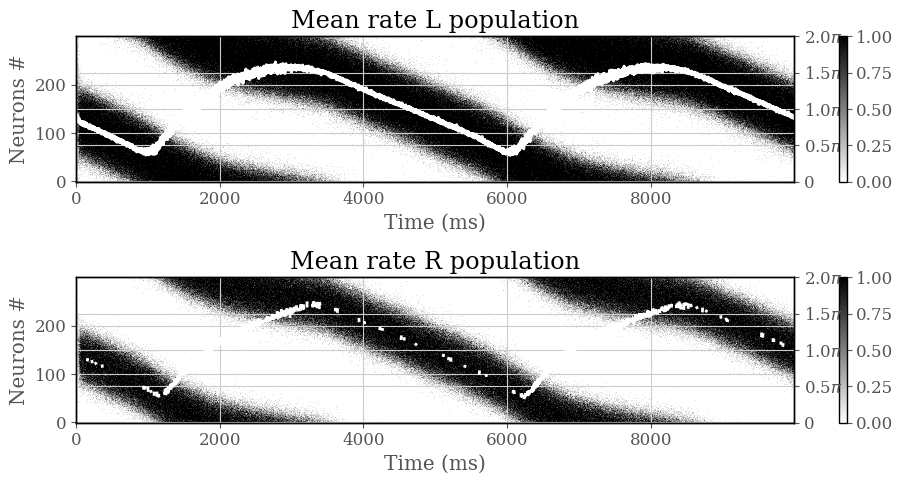

In [73]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
mean_rate_l = calculate_mean_rate(N, T, dt, spikes_l)
mean_over_time_l = np.mean(mean_rate_l, axis=1)
im = ax[0].imshow(mean_rate_l, aspect='auto', origin='lower')
ax[0].set_ylabel('Neurons #')
ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Mean rate L population')
plt.colorbar(im)
max_neuron_rate_l = []
for t in range(1, T):
    # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    if np.sum(mean_rate_l[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_l[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
        top_neurons_l = np.argpartition(mean_rate_l[:, t], -100)[-100:]
        max_neuron_rate_l.append(np.mean(top_neurons_l))
    else:
        max_neuron_rate_l.append(np.nan)
# mean_over_neurons = np.mean(mean_rate, axis=0)
# plt.plot(max_neuron_rate, color='white')
ax1 = ax[0].twinx()
max_neuron_rate_l = np.array(max_neuron_rate_l)
max_angle_l = map_to_degree(max_neuron_rate_l, N)
ax1.plot(max_angle_l, color='white')
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 

mean_rate_r = calculate_mean_rate(N, T, dt, spikes_r)
mean_over_time_r = np.mean(mean_rate_r, axis=1)
im = ax[1].imshow(mean_rate_r, aspect='auto', origin='lower')
ax[1].set_ylabel('Neurons #')
ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Mean rate R population')
plt.colorbar(im)
max_neuron_rate_r = []
for t in range(1, T):
    # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    if np.sum(mean_rate_r[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_r[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
        top_neurons_r = np.argpartition(mean_rate_r[:, t], -100)[-100:]
        max_neuron_rate_r.append(np.mean(top_neurons_r))
    else:
        max_neuron_rate_r.append(np.nan)
# mean_over_neurons = np.mean(mean_rate, axis=0)
# plt.plot(max_neuron_rate, color='white')
ax1 = ax[1].twinx()
max_neuron_rate_r = np.array(max_neuron_rate_r)
max_angle_r = map_to_degree(max_neuron_rate_r, N)
ax1.plot(max_angle_r, color='white')
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 


In [191]:
# Cheking only for 1 itteration
# global parameters
T = 2000 # ms
dt = .1 # ms
N = 300
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

# parameters for the left and right populations
Xl = np.linspace(0, 2 * np.pi, N)
Xr = np.linspace(0, 2 * np.pi, N)
theta_l = 10 * np.pi / 180
theta_r = 10 * np.pi / 180

# initial conditions for h such that the center of the bump remains around pi
# creating initial values for the neurons such that the centering neuron has the highest rate
peak_index = 150
std_dev = 50
indices = np.arange(N)
normal_dist = np.exp(-((indices - peak_index) ** 2) / (2 * std_dev ** 2))
initial_array = normal_dist * np.random.normal(0, .3, N)
initial_array = np.abs(initial_array)

I0_range = np.linspace(-1.5, 1.5, 51)
theta_bump_final_l = []
theta_bump_final_r = []

for I0 in I0_range:
    Il = np.zeros((N, int(T/dt)))
    Ir = np.zeros((N, int(T/dt)))
    hl = np.random.uniform(0, 1, (N, int(T/dt)))
    hr = np.random.uniform(0, 1, (N, int(T/dt)))
    spikes_l = np.zeros((N, int(T/dt)))
    spikes_r = np.zeros((N, int(T/dt)))
    rate_l = np.zeros((N, int(T/dt)))
    rate_r = np.zeros((N, int(T/dt)))
    m_cos_l = 0
    m_cos_r = 0
    m_sin_l = 0
    m_sin_r = 0
    Jl = 3
    Jr = 3
    hl[:, 0] = initial_array
    hr[:, 0] = initial_array
    # simulation of both populations
    for t in range(1, int(T/dt)):
        Il[:, t] = Jl * (np.cos(Xl+theta_l) * m_cos_l + np.sin(Xl+theta_l) * m_sin_l) + Jr * (np.cos(Xl+theta_l) * m_cos_r + np.sin(Xl+theta_l) * m_sin_r)
        Ir[:, t] = Jr * (np.cos(Xr-theta_r) * m_cos_r + np.sin(Xr-theta_r) * m_sin_r) + Jl * (np.cos(Xr-theta_r) * m_cos_l + np.sin(Xr-theta_r) * m_sin_l)
        
        if t >= int(300/dt) and t < int(600/dt):
            # Il[:, t] = Il[:, t] + np.ones(N) * I0
            # Ir[:, t] = Ir[:, t] - np.ones(N) * I0
            Il[:, t] = Il[:, t] - I0
            Ir[:, t] = Ir[:, t] + I0

        hl[:, t] = hl[:, t-1] + dt * dhdt(hl[:, t-1], Il[:, t-1], tau, R)
        hr[:, t] = hr[:, t-1] + dt * dhdt(hr[:, t-1], Ir[:, t-1], tau, R)
        
        rate_l[:, t] = r0 * transfer(hl[:, t], alpha, beta)
        rate_r[:, t] = r0 * transfer(hr[:, t], alpha, beta)
        
        spikes_l[:, t] = np.random.binomial(1, rate_l[:, t] * dt)
        spikes_r[:, t] = np.random.binomial(1, rate_r[:, t] * dt)
        
        m_cos_l = np.mean(np.cos(Xl) * spikes_l[:, t])
        m_cos_r = np.mean(np.cos(Xr) * spikes_r[:, t])
        
        m_sin_l = np.mean(np.sin(Xl) * spikes_l[:, t])
        m_sin_r = np.mean(np.sin(Xr) * spikes_r[:, t])
    
    # figure = plt.figure(figsize=(10, 10))
    # plt.subplot(611)
    # plt.plot(Il.T, color = 'red', alpha = .1)
    # plt.ylabel('Input current L')
    # plt.subplot(612)
    # plt.plot(rate_l.T, color = 'red', alpha = .1)
    # plt.ylabel('Rate L')
    # plt.subplot(613)
    # # plotting the spike raster
    # for n in range(N):
    #     spikes_n = np.where(spikes_l[n, :])[0]
    #     plt.vlines(spikes_n, n-.5e1, n+.5e1, color='red')
    # plt.xlabel('Time (ms)')
    # plt.ylabel('Neurons # L')
    # plt.title('Spike raster L')

    # plt.subplot(614)
    # plt.plot(Ir.T, color = 'blue', alpha = .1)
    # plt.ylabel('Input current R')
    # plt.subplot(615)
    # plt.plot(rate_r.T, color = 'blue', alpha = .1)
    # plt.ylabel('Rate R')
    # plt.subplot(616)
    # # plotting the spike raster
    # for n in range(N):
    #     spikes_n = np.where(spikes_r[n, :])[0]
    #     plt.vlines(spikes_n, n-.5e1, n+.5e1, color='blue')
    # plt.xlabel('Time (ms)')
    # plt.ylabel('Neurons # R')
    # plt.title('Spike raster')
    # plt.savefig('spike_raster_I0_{}.png'.format(I0))
    
    mean_rate_l = calculate_mean_rate(N, T, dt, spikes_l)
    mean_rate_r = calculate_mean_rate(N, T, dt, spikes_r)
    
    max_neuron_rate_l = []
    max_neuron_rate_r = []
    
    for t in range(1, T):
        if np.sum(mean_rate_l[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_l[:, t], axis=0) > N/3:
            max_neuron_rate_l.append(np.argmax(mean_rate_l[:, t]))
        else:
            max_neuron_rate_l.append(np.nan)
        
        if np.sum(mean_rate_r[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_r[:, t], axis=0) > N/3:
            max_neuron_rate_r.append(np.argmax(mean_rate_r[:, t]))
        else:
            max_neuron_rate_r.append(np.nan)
    max_neuron_rate_r = np.array(max_neuron_rate_r)
    max_angle_r = map_to_degree(max_neuron_rate_r, N)
    max_neuron_rate_l = np.array(max_neuron_rate_l)
    max_angle_l = map_to_degree(max_neuron_rate_l, N)

    theta_bump_final_l.append(max_angle_l[-1])
    theta_bump_final_r.append(max_angle_r[-1])

theta_bump_final_l = np.array(theta_bump_final_l)
theta_bump_final_r = np.array(theta_bump_final_r)
mean_theta_bump = (theta_bump_final_l + theta_bump_final_r) / 2


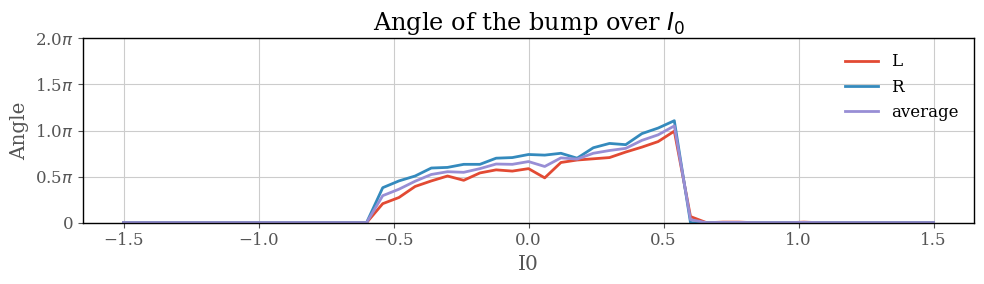

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(I0_range, theta_bump_final_l, label='L')
ax.plot(I0_range, theta_bump_final_r, label='R')
ax.plot(I0_range, mean_theta_bump, label='average')
ax.set_xlabel('I0') 
ax.set_ylabel('Angle')
ax.legend()
ax.set_title(r'Angle of the bump over $I_0$')
ax.set_ylim(0, 2 * np.pi)
ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 

plt.savefig('angle_over_I0_radian.pdf')

# 2.4
A good upper limit on the input strength such that the relation between I0 and the final bump location is 
$ | I_0 | \simeq 0.5 $


# 2.5 
We started the initial condition such that the bump remain at $\sim \pi$. With too strong external input, the internal connectivity cannot hold the network stability and the bump will disappear. With sufficiently strong input (not too strong to disturb the whole system) we can move the location of the bump attractor to either left or right side depending on the sign of the external input. After the external input is gone, the location of the bump continues its previous configuration and thus the system can hold the memory of the external applied input.

# 3.1
The implementation of the `generate_trajectory` function is based on a Gaussian random walk.

The heading direction `theta_H` is updated at each time step by adding a small random perturbation drawn from a normal distribution. This ensures that the heading direction changes smoothly over time, without any abrupt jumps.

The 2D position is updated based on the current heading direction and a constant speed. This ensures that the trajectory moves at a constant speed in the direction of the current heading.

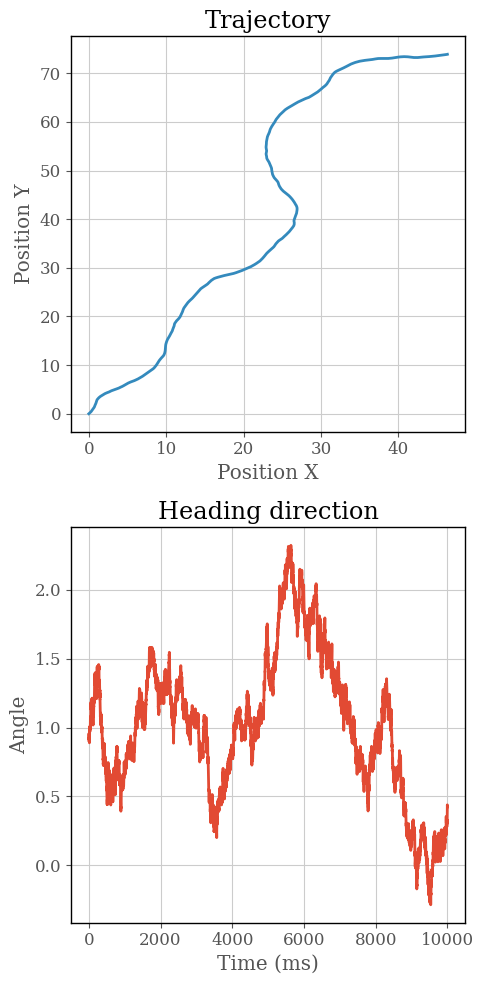

In [167]:
theta_H, position = generate_trajectory(T = 1000, dt = .1, speed = .1, std_dev = .02)
plt.figure(figsize=(5, 10))
plt.subplot(211)
plt.plot(position[0, 0], position[0, 1])
plt.plot(position[:, 0], position[:, 1])
plt.title('Trajectory')
plt.ylabel('Position Y')
plt.xlabel('Position X')
plt.subplot(212)
plt.title('Heading direction')
plt.plot(theta_H)
plt.ylabel('Angle')
plt.xlabel('Time (ms)')
plt.tight_layout()

# 3.2

In [168]:
T = 1000 # ms
dt = .1 # ms
N = 300
X = np.linspace(0, 2 * np.pi, N)
I = np.zeros((N, int(T/dt)))
h = np.random.uniform(0, 1, (N, int(T/dt)))
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV
# h = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))
rate = np.zeros((N, int(T/dt)))
I_ext = np.zeros((N, int(T/dt)))
I0 = 1
m_cos = 0
m_sin = 0
J = 5
# spikes = np.random.binomial(1, np.ones(N) * dt, (N, int(T/dt)))
# h = np.random.normal(0, 1, (N, int(T/dt)))
for t in range(1, int(T/dt)):
    I[:, t] = J * (np.cos(X) * m_cos + np.sin(X) * m_sin)
    I_ext[:, t] = I0 * np.cos(X - theta_H[t])
    I[:, t] = I[:, t] + I_ext[:, t]
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    m_cos = np.mean(np.cos(X) * spikes[:, t])
    m_sin = np.mean(np.sin(X) * spikes[:, t])

# figure = plt.figure(figsize=(5, 10))
# plt.subplot(411)
# plt.plot(I.T, color = 'black', alpha = .1)
# plt.ylabel('Input current')
# plt.subplot(412)
# plt.plot(rate.T, color = 'red', alpha = .1)
# plt.ylabel('Rate')
# plt.subplot(413)
# # plotting the spike raster
# # for n in range(N):
# #     spikes_n = np.where(spikes[n, :])[0]
# #     plt.vlines(spikes_n, n-.5e1, n+.5e1, color='black')
# # plt.xlabel('Time (ms)')
# # plt.ylabel('Neurons #')
# # plt.title('Spike raster')
# plt.subplot(414)
# plt.plot(theta_H, 'r')


In [188]:
mean_rate.shape

(300, 1000)

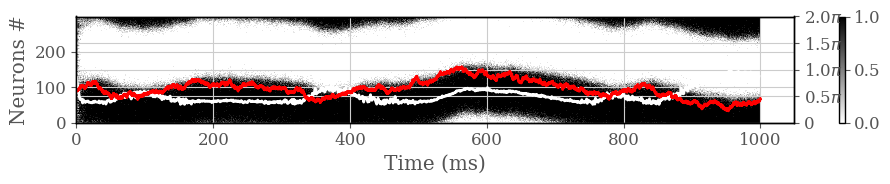

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
mean_rate = calculate_mean_rate(N, T, dt, spikes)
mean_over_time = np.mean(mean_rate, axis=1)
im = ax.imshow(mean_rate, aspect='auto', origin='lower')
ax.set_ylabel('Neurons #')
ax.set_xlabel('Time (ms)')
plt.colorbar(im)
max_neuron_rate = []
for t in range(1, T):
    # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    if np.sum(mean_rate[:, t], axis=0) < 2*N/3 and np.sum(mean_rate[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
        top_neurons = np.argpartition(mean_rate[:, t], -100)[-100:]
        max_neuron_rate.append(np.mean(top_neurons))
    else:
        max_neuron_rate.append(np.nan)
# mean_over_neurons = np.mean(mean_rate, axis=0)
# plt.plot(max_neuron_rate, color='white')
ax1 = ax.twinx()
max_neuron_rate = np.array(max_neuron_rate)
max_angle = map_to_degree(max_neuron_rate, N)
ax1.plot(max_angle, color='white')
ax1.plot(np.arange(0,T,dt),theta_H - np.mean(theta_H) + 2, 'r')
# ax1.set_ylim(0, 360)
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 


# 3.2 
Yes, it does match well.

# 3.3

In [170]:
# Cheking only for 1 itteration
# global parameters
T = 1000 # ms
dt = .1 # ms
N = 300
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

# parameters for the left and right populations
Xl = np.linspace(0, 2 * np.pi, N)
Xr = np.linspace(0, 2 * np.pi, N)
Xh = np.linspace(0, 2 * np.pi, N)

theta_l = 10 * np.pi / 180
theta_r = 10 * np.pi / 180

Il = np.zeros((N, int(T/dt)))
Ir = np.zeros((N, int(T/dt)))
Ih = np.zeros((N, int(T/dt)))
hl = np.random.uniform(0, 1, (N, int(T/dt)))
hr = np.random.uniform(0, 1, (N, int(T/dt)))
hh = np.random.uniform(0, 1, (N, int(T/dt)))

spikes_l = np.zeros((N, int(T/dt)))
spikes_r = np.zeros((N, int(T/dt)))
spikes_h = np.zeros((N, int(T/dt)))

rate_l = np.zeros((N, int(T/dt)))
rate_r = np.zeros((N, int(T/dt)))
rate_h = np.zeros((N, int(T/dt)))

m_cos_l = 0
m_cos_r = 0
m_cos_h = 0

m_sin_l = 0
m_sin_r = 0
m_sin_h = 0

Jl = 3
Jr = 3

Jh = 5
Jhead = 0.5

# initial conditions for h such that the center of the bump remains around pi
# creating initial values for the neurons such that the centering neuron has the highest rate
peak_index = 150
std_dev = 50
indices = np.arange(N)
normal_dist = np.exp(-((indices - peak_index) ** 2) / (2 * std_dev ** 2))
initial_array = normal_dist * np.random.normal(0, .3, N)
initial_array = np.abs(initial_array)

hl[:, 0] = initial_array
hr[:, 0] = initial_array
hh[:, 0] = initial_array

I0 = 1
# simulation of both populations
for t in range(1, int(T/dt)):
    
    Ih[:, t] = Jh * (np.cos(Xh) * m_cos_h + np.sin(Xh) * m_sin_h)
    Il[:, t] = Jl * (np.cos(Xl+theta_l) * m_cos_l + np.sin(Xl+theta_l) * m_sin_l) + Jr * (np.cos(Xl+theta_l) * m_cos_r + np.sin(Xl+theta_l) * m_sin_r)
    Ir[:, t] = Jr * (np.cos(Xr-theta_r) * m_cos_r + np.sin(Xr-theta_r) * m_sin_r) + Jl * (np.cos(Xr-theta_r) * m_cos_l + np.sin(Xr-theta_r) * m_sin_l)
    
    I_ext[:, t] = I0 * np.cos(Xh - theta_H[t])
    Ih[:, t] = Ih[:, t] + I_ext[:, t]
    
    Il[:, t] = Il[:, t] - Jhead * np.cos(Xh - theta_H[t])
    Ir[:, t] = Ir[:, t] + Jhead * np.cos(Xh - theta_H[t])

    hh[:, t] = hh[:, t-1] + dt * dhdt(hh[:, t-1], Ih[:, t-1], tau, R)
    hl[:, t] = hl[:, t-1] + dt * dhdt(hl[:, t-1], Il[:, t-1], tau, R)
    hr[:, t] = hr[:, t-1] + dt * dhdt(hr[:, t-1], Ir[:, t-1], tau, R)
    
    rate_h[:, t] = r0 * transfer(hh[:, t], alpha, beta)
    rate_l[:, t] = r0 * transfer(hl[:, t], alpha, beta)
    rate_r[:, t] = r0 * transfer(hr[:, t], alpha, beta)
    
    spikes_h[:, t] = np.random.binomial(1, rate_h[:, t] * dt)
    spikes_l[:, t] = np.random.binomial(1, rate_l[:, t] * dt)
    spikes_r[:, t] = np.random.binomial(1, rate_r[:, t] * dt)
    
    m_cos_h = np.mean(np.cos(Xh) * spikes_h[:, t])
    m_sin_h = np.mean(np.sin(Xh) * spikes_h[:, t])
    
    m_cos_l = np.mean(np.cos(Xl) * spikes_l[:, t])
    m_cos_r = np.mean(np.cos(Xr) * spikes_r[:, t])
    
    m_sin_l = np.mean(np.sin(Xl) * spikes_l[:, t])
    m_sin_r = np.mean(np.sin(Xr) * spikes_r[:, t])



Text(0.5, 1.0, 'Spike raster')

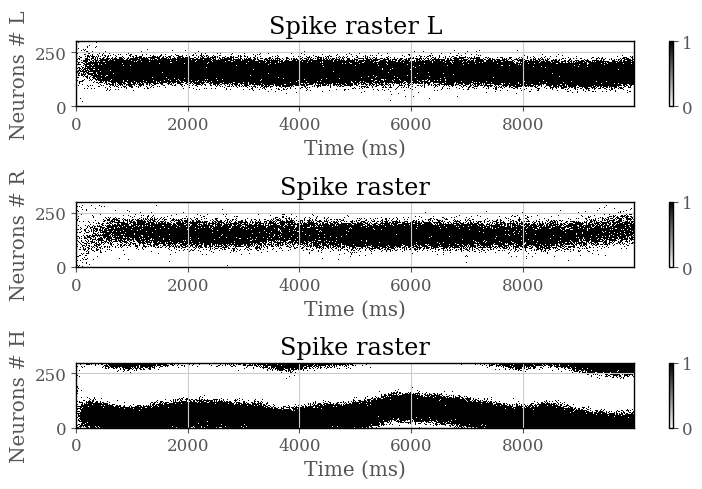

In [171]:
figure = plt.figure(figsize=(8, 5))
plt.subplot(311)
plt.imshow(spikes_l, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Neurons # L')
plt.title('Spike raster L')
plt.subplot(312)
plt.imshow(spikes_r, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Neurons # R')
plt.title('Spike raster')

plt.subplot(313)
plt.imshow(spikes_h, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Neurons # H')
plt.title('Spike raster')

In [173]:
# def interactive_head_x(Jh = 5, Jhead = 1):
#     # Cheking only for 1 itteration
#     # global parameters
#     T = 1000 # ms
#     dt = .1 # ms
#     N = 600
#     tau = 10 # ms
#     R = 1 # Ohm # needs to be asked on the units
#     r0 = 10 # mHz
#     alpha = 2 # mV^-1
#     beta = .5 # mV

#     # parameters for the left and right populations
#     Xl = np.linspace(0, 2 * np.pi, N)
#     Xr = np.linspace(0, 2 * np.pi, N)
#     Xh = np.linspace(0, 2 * np.pi, N)

#     theta_l = 10 * np.pi / 180
#     theta_r = 10 * np.pi / 180

#     Il = np.zeros((N, int(T/dt)))
#     Ir = np.zeros((N, int(T/dt)))
#     Ih = np.zeros((N, int(T/dt)))
#     hl = np.random.uniform(0, 1, (N, int(T/dt)))
#     hr = np.random.uniform(0, 1, (N, int(T/dt)))
#     hh = np.random.uniform(0, 1, (N, int(T/dt)))

#     spikes_l = np.zeros((N, int(T/dt)))
#     spikes_r = np.zeros((N, int(T/dt)))
#     spikes_h = np.zeros((N, int(T/dt)))

#     rate_l = np.zeros((N, int(T/dt)))
#     rate_r = np.zeros((N, int(T/dt)))
#     rate_h = np.zeros((N, int(T/dt)))

#     m_cos_l = 0
#     m_cos_r = 0
#     m_cos_h = 0

#     m_sin_l = 0
#     m_sin_r = 0
#     m_sin_h = 0

#     Jl = 3
#     Jr = 3

#     # initial conditions for h such that the center of the bump remains around pi
#     # creating initial values for the neurons such that the centering neuron has the highest rate
#     peak_index = 150
#     std_dev = 50
#     indices = np.arange(N)
#     normal_dist = np.exp(-((indices - peak_index) ** 2) / (2 * std_dev ** 2))
#     initial_array = normal_dist * np.random.normal(0, .3, N)
#     initial_array = np.abs(initial_array)

#     # hl[:, 0] = initial_array
#     # hr[:, 0] = initial_array
#     # hh[:, 0] = initial_array

#     I0 = 1
#     # simulation of both populations
#     for t in range(1, int(T/dt)):
        
#         Ih[:, t] = Jh * (np.cos(Xh) * m_cos_h + np.sin(Xh) * m_sin_h)
#         Il[:, t] = Jl * (np.cos(Xl+theta_l) * m_cos_l + np.sin(Xl+theta_l) * m_sin_l) + Jr * (np.cos(Xl+theta_l) * m_cos_r + np.sin(Xl+theta_l) * m_sin_r)
#         Ir[:, t] = Jr * (np.cos(Xr-theta_r) * m_cos_r + np.sin(Xr-theta_r) * m_sin_r) + Jl * (np.cos(Xr-theta_r) * m_cos_l + np.sin(Xr-theta_r) * m_sin_l)
        
#         I_ext[:, t] = I0 * np.cos(Xh - theta_H[t])
#         Ih[:, t] = Ih[:, t] + I_ext[:, t]
        
#         Il[:, t] = Il[:, t] - Jhead * np.cos(Xh - theta_H[t])
#         Ir[:, t] = Ir[:, t] + Jhead * np.cos(Xh - theta_H[t])

#         hh[:, t] = hh[:, t-1] + dt * dhdt(hh[:, t-1], Ih[:, t-1], tau, R)
#         hl[:, t] = hl[:, t-1] + dt * dhdt(hl[:, t-1], Il[:, t-1], tau, R)
#         hr[:, t] = hr[:, t-1] + dt * dhdt(hr[:, t-1], Ir[:, t-1], tau, R)
        
#         rate_h[:, t] = r0 * transfer(hh[:, t], alpha, beta)
#         rate_l[:, t] = r0 * transfer(hl[:, t], alpha, beta)
#         rate_r[:, t] = r0 * transfer(hr[:, t], alpha, beta)
        
#         spikes_h[:, t] = np.random.binomial(1, rate_h[:, t] * dt)
#         spikes_l[:, t] = np.random.binomial(1, rate_l[:, t] * dt)
#         spikes_r[:, t] = np.random.binomial(1, rate_r[:, t] * dt)
        
#         m_cos_h = np.mean(np.cos(Xh) * spikes_h[:, t])
#         m_sin_h = np.mean(np.sin(Xh) * spikes_h[:, t])
        
#         m_cos_l = np.mean(np.cos(Xl) * spikes_l[:, t])
#         m_cos_r = np.mean(np.cos(Xr) * spikes_r[:, t])
        
#         m_sin_l = np.mean(np.sin(Xl) * spikes_l[:, t])
#         m_sin_r = np.mean(np.sin(Xr) * spikes_r[:, t])

#     figure = plt.figure(figsize=(10, 5))
#     plt.subplot(311)
#     plt.imshow(spikes_l, aspect='auto', origin='lower')
#     plt.colorbar()
#     plt.xlabel('Time (ms)')
#     plt.ylabel('Neurons # L')
#     plt.title('Spike raster L')
#     plt.subplot(312)
#     plt.imshow(spikes_r, aspect='auto', origin='lower')
#     plt.colorbar()
#     plt.xlabel('Time (ms)')
#     plt.ylabel('Neurons # R')
#     plt.title('Spike raster')

#     plt.subplot(313)
#     plt.imshow(spikes_h, aspect='auto', origin='lower')
#     plt.colorbar()
#     plt.xlabel('Time (ms)')
#     plt.ylabel('Neurons # H')
#     plt.title('Spike raster')

# _ = interact(interactive_head_x, Jh = (1, 10, .1), Jhead = (0, 10, .1))

In [174]:
# Cheking only for 1 itteration
# global parameters
T = 1000 # ms
dt = .1 # ms
N = 300
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

# parameters for the left and right populations
Xl = np.linspace(0, 2 * np.pi, N)
Xr = np.linspace(0, 2 * np.pi, N)
Xh = np.linspace(0, 2 * np.pi, N)

theta_l = 10 * np.pi / 180
theta_r = 10 * np.pi / 180

Il = np.zeros((N, int(T/dt)))
Ir = np.zeros((N, int(T/dt)))
Ih = np.zeros((N, int(T/dt)))
hl = np.random.uniform(0, 1, (N, int(T/dt)))
hr = np.random.uniform(0, 1, (N, int(T/dt)))
hh = np.random.uniform(0, 1, (N, int(T/dt)))

spikes_l = np.zeros((N, int(T/dt)))
spikes_r = np.zeros((N, int(T/dt)))
spikes_h = np.zeros((N, int(T/dt)))

rate_l = np.zeros((N, int(T/dt)))
rate_r = np.zeros((N, int(T/dt)))
rate_h = np.zeros((N, int(T/dt)))

m_cos_l = 0
m_cos_r = 0
m_cos_h = 0

m_sin_l = 0
m_sin_r = 0
m_sin_h = 0

Jl = 3
Jr = 3

# initial conditions for h such that the center of the bump remains around pi
# creating initial values for the neurons such that the centering neuron has the highest rate
peak_index = 150
std_dev = 50
indices = np.arange(N)
normal_dist = np.exp(-((indices - peak_index) ** 2) / (2 * std_dev ** 2))
initial_array = normal_dist * np.random.normal(0, .3, N)
initial_array = np.abs(initial_array)

hl[:, 0] = initial_array
hr[:, 0] = initial_array
hh[:, 0] = initial_array

Jhead_range = np.linspace(-1.5, 1.5, 11)
theta_bump_final_l = []
theta_bump_final_r = []

for Jhead in Jhead_range:
    Il = np.zeros((N, int(T/dt)))
    Ir = np.zeros((N, int(T/dt)))
    hl = np.random.uniform(0, 1, (N, int(T/dt)))
    hr = np.random.uniform(0, 1, (N, int(T/dt)))
    spikes_l = np.zeros((N, int(T/dt)))
    spikes_r = np.zeros((N, int(T/dt)))
    rate_l = np.zeros((N, int(T/dt)))
    rate_r = np.zeros((N, int(T/dt)))
    m_cos_l = 0
    m_cos_r = 0
    m_sin_l = 0
    m_sin_r = 0
    hl[:, 0] = initial_array
    hr[:, 0] = initial_array
    # simulation of both populations
    for t in range(1, int(T/dt)):
        Ih[:, t] = Jh * (np.cos(Xh) * m_cos_h + np.sin(Xh) * m_sin_h)
        Il[:, t] = Jl * (np.cos(Xl+theta_l) * m_cos_l + np.sin(Xl+theta_l) * m_sin_l) + Jr * (np.cos(Xl+theta_l) * m_cos_r + np.sin(Xl+theta_l) * m_sin_r)
        Ir[:, t] = Jr * (np.cos(Xr-theta_r) * m_cos_r + np.sin(Xr-theta_r) * m_sin_r) + Jl * (np.cos(Xr-theta_r) * m_cos_l + np.sin(Xr-theta_r) * m_sin_l)
        
        I_ext[:, t] = I0 * np.cos(Xh - theta_H[t])
        Ih[:, t] = Ih[:, t] + I_ext[:, t]
        
        Il[:, t] = Il[:, t] - Jhead * np.cos(Xh - theta_H[t])
        Ir[:, t] = Ir[:, t] + Jhead * np.cos(Xh - theta_H[t])

        hh[:, t] = hh[:, t-1] + dt * dhdt(hh[:, t-1], Ih[:, t-1], tau, R)
        hl[:, t] = hl[:, t-1] + dt * dhdt(hl[:, t-1], Il[:, t-1], tau, R)
        hr[:, t] = hr[:, t-1] + dt * dhdt(hr[:, t-1], Ir[:, t-1], tau, R)
        
        rate_h[:, t] = r0 * transfer(hh[:, t], alpha, beta)
        rate_l[:, t] = r0 * transfer(hl[:, t], alpha, beta)
        rate_r[:, t] = r0 * transfer(hr[:, t], alpha, beta)
        
        spikes_h[:, t] = np.random.binomial(1, rate_h[:, t] * dt)
        spikes_l[:, t] = np.random.binomial(1, rate_l[:, t] * dt)
        spikes_r[:, t] = np.random.binomial(1, rate_r[:, t] * dt)
        
        m_cos_h = np.mean(np.cos(Xh) * spikes_h[:, t])
        m_sin_h = np.mean(np.sin(Xh) * spikes_h[:, t])
        
        m_cos_l = np.mean(np.cos(Xl) * spikes_l[:, t])
        m_cos_r = np.mean(np.cos(Xr) * spikes_r[:, t])
        
        m_sin_l = np.mean(np.sin(Xl) * spikes_l[:, t])
        m_sin_r = np.mean(np.sin(Xr) * spikes_r[:, t])
    
    mean_rate_l = calculate_mean_rate(N, T, dt, spikes_l)
    mean_rate_r = calculate_mean_rate(N, T, dt, spikes_r)
    
    max_neuron_rate_l = []
    max_neuron_rate_r = []
    
    for t in range(1, T):
        if np.sum(mean_rate_l[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_l[:, t], axis=0) > N/3:
            max_neuron_rate_l.append(np.argmax(mean_rate_l[:, t]))
        else:
            max_neuron_rate_l.append(np.nan)
        
        if np.sum(mean_rate_r[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_r[:, t], axis=0) > N/3:
            max_neuron_rate_r.append(np.argmax(mean_rate_r[:, t]))
        else:
            max_neuron_rate_r.append(np.nan)
    max_neuron_rate_r = np.array(max_neuron_rate_r)
    max_angle_r = map_to_degree(max_neuron_rate_r, N)
    max_neuron_rate_l = np.array(max_neuron_rate_l)
    max_angle_l = map_to_degree(max_neuron_rate_l, N)

    theta_bump_final_l.append(max_angle_l[-1])
    theta_bump_final_r.append(max_angle_r[-1])

theta_bump_final_l = np.array(theta_bump_final_l)
theta_bump_final_r = np.array(theta_bump_final_r)
mean_theta_bump = (theta_bump_final_l + theta_bump_final_r) / 2


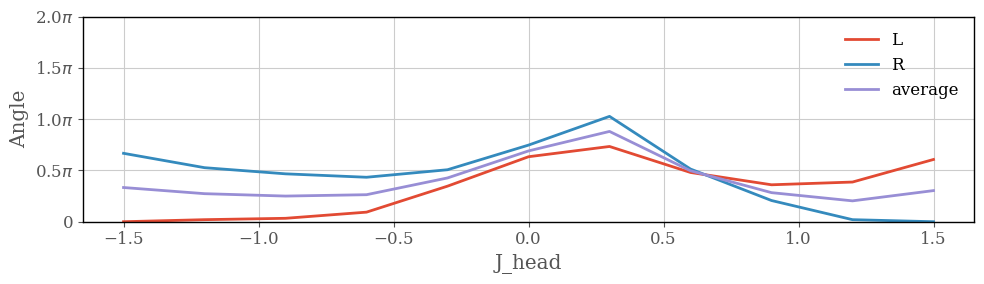

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(Jhead_range, theta_bump_final_l, label='L')
ax.plot(Jhead_range, theta_bump_final_r, label='R')
ax.plot(Jhead_range, mean_theta_bump, label='average')
ax.set_xlabel('J_head') 
ax.set_ylabel('Angle')
ax.legend()
# ax.set_title(r'J head')
ax.set_ylim(0, 2 * np.pi)
ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 

plt.savefig('figures/3.3.pdf')

# 3.4
The input that each neuron in $L$ population receives is:
$$
I_i^L = \frac{J^L}{N} \sum_{j=1}^{N^L} w_{L \rightarrow L}(x_i^L, x_j^L) S_j^L(t) 
 + \frac{J^R}{N} \sum_{j=1}^{N^R} w_{R \rightarrow L}(x_i^R, x_j^R) S_j^R(t) - \frac{J_{\text{head}}}{N} \sum_j \cos(x_j^H - \theta^H)
$$
and the input that each neuron in $R$ population receives is:
$$
I_i^R = \frac{J^R}{N} \sum_{j=1}^{N^R} w_{R \rightarrow R}(x_i^R, x_j^R) S_j^R(t)
+ \frac{J^L}{N} \sum_{j=1}^{N^L} w_{L \rightarrow R}(x_i^L, x_j^L) S_j^L(t) + \frac{J_{\text{head}}}{N} \sum_j \cos(x_j^H - \theta^H)
$$

and for the head cells:
$$
I_i^H = \frac{J^H}{N} \sum_{j=1}^{N^H} w_{H \rightarrow H}(x_i^H, x_j^H) S_j^H(t)
$$


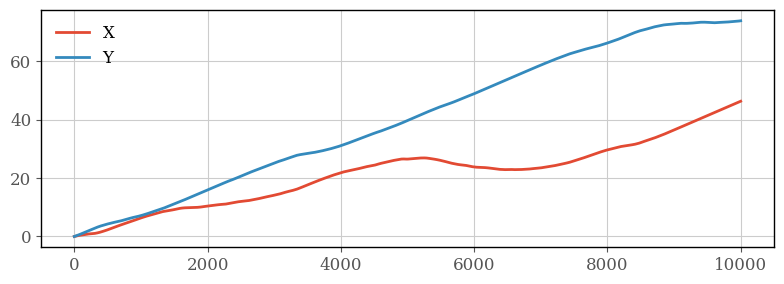

In [176]:
plt.figure(figsize=(8,3))
plt.plot(position[:, 0], label='X')
plt.plot(position[:, 1], label='Y')
plt.legend()

# 3.5
We tried to develope the 5 populations but it didn't work given the instruction.
We then changed the expternal input from head direction cells to the four other populations by:
$$
\frac{J_{\text{head}}}{N} \sum_j \cos(x_j^H - \theta^H)
$$



In [177]:
# Cheking only for 1 itteration
# global parameters
T = 1000 # ms
dt = .1 # ms
N = 300
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

# parameters for the left and right populations
Xlx = np.linspace(0, 2 * np.pi, N)
Xrx = np.linspace(0, 2 * np.pi, N)
Xly = np.linspace(0, 2 * np.pi, N)
Xry = np.linspace(0, 2 * np.pi, N)
Xh = np.linspace(0, 2 * np.pi, N)

theta_lx = 10 * np.pi / 180
theta_rx = 10 * np.pi / 180
theta_ly = 10 * np.pi / 180
theta_ry = 10 * np.pi / 180

Ilx = np.zeros((N, int(T/dt)))
Irx = np.zeros((N, int(T/dt)))
Ily = np.zeros((N, int(T/dt)))
Iry = np.zeros((N, int(T/dt)))
Ih = np.zeros((N, int(T/dt)))

hlx = np.random.uniform(0, 1, (N, int(T/dt)))
hrx = np.random.uniform(0, 1, (N, int(T/dt)))
hly = np.random.uniform(0, 1, (N, int(T/dt)))
hry = np.random.uniform(0, 1, (N, int(T/dt)))
hh = np.random.uniform(0, 1, (N, int(T/dt)))


spikes_lx = np.zeros((N, int(T/dt)))
spikes_rx = np.zeros((N, int(T/dt)))
spikes_ly = np.zeros((N, int(T/dt)))
spikes_ry = np.zeros((N, int(T/dt)))

spikes_h = np.zeros((N, int(T/dt)))

rate_lx = np.zeros((N, int(T/dt)))
rate_rx = np.zeros((N, int(T/dt)))
rate_ly = np.zeros((N, int(T/dt)))
rate_ry = np.zeros((N, int(T/dt)))

rate_h = np.zeros((N, int(T/dt)))

m_cos_lx = 0
m_cos_rx = 0
m_cos_ly = 0
m_cos_ry = 0

m_cos_h = 0

m_sin_lx = 0
m_sin_rx = 0
m_sin_ly = 0
m_sin_ry = 0

m_sin_h = 0

Jl = 3
Jr = 3

Jh = 5
Jhead = 0.5

# initial conditions for h such that the center of the bump remains around pi
# creating initial values for the neurons such that the centering neuron has the highest rate
peak_index = 150
std_dev = 50
indices = np.arange(N)
normal_dist = np.exp(-((indices - peak_index) ** 2) / (2 * std_dev ** 2))
initial_array = normal_dist * np.random.normal(0, .3, N)
initial_array = np.abs(initial_array)

hlx[:, 0] = initial_array
hrx[:, 0] = initial_array
hly[:, 0] = initial_array
hry[:, 0] = initial_array
hh[:, 0] = initial_array

I0 = 1
# simulation of both populations
for t in range(1, int(T/dt)):
    
    Ih[:, t] = Jh * (np.cos(Xh) * m_cos_h + np.sin(Xh) * m_sin_h)
    
    Ilx[:, t] = Jl * (np.cos(Xlx+theta_lx) * m_cos_lx + np.sin(Xlx+theta_lx) * m_sin_lx) + Jr * (np.cos(Xlx+theta_lx) * m_cos_rx + np.sin(Xlx+theta_lx) * m_sin_rx)
    Irx[:, t] = Jr * (np.cos(Xrx-theta_rx) * m_cos_rx + np.sin(Xrx-theta_rx) * m_sin_rx) + Jl * (np.cos(Xrx-theta_rx) * m_cos_lx + np.sin(Xrx-theta_rx) * m_sin_lx)
    
    Ily[:, t] = Jl * (np.cos(Xly+theta_ly) * m_cos_ly + np.sin(Xly+theta_ly) * m_sin_ly) + Jr * (np.cos(Xly+theta_ly) * m_cos_ry + np.sin(Xly+theta_ly) * m_sin_ry)
    Iry[:, t] = Jr * (np.cos(Xry-theta_ry) * m_cos_ry + np.sin(Xry-theta_ry) * m_sin_ry) + Jl * (np.cos(Xry-theta_ry) * m_cos_ly + np.sin(Xry-theta_ry) * m_sin_ly)
    
    I_ext[:, t] = I0 * np.cos(Xh - theta_H[t])
    Ih[:, t] = Ih[:, t] + I_ext[:, t]
    
    Ilx[:, t] = Ilx[:, t] - Jhead * np.cos(Xh - theta_H[t])
    Irx[:, t] = Irx[:, t] + Jhead * np.cos(Xh - theta_H[t])

    Ily[:, t] = Ily[:, t] - Jhead * np.sin(Xh - theta_H[t])
    Iry[:, t] = Iry[:, t] + Jhead * np.sin(Xh - theta_H[t])


    hh[:, t] = hh[:, t-1] + dt * dhdt(hh[:, t-1], Ih[:, t-1], tau, R)
    
    hlx[:, t] = hlx[:, t-1] + dt * dhdt(hlx[:, t-1], Ilx[:, t-1], tau, R)
    hrx[:, t] = hrx[:, t-1] + dt * dhdt(hrx[:, t-1], Irx[:, t-1], tau, R)
    
    hly[:, t] = hly[:, t-1] + dt * dhdt(hly[:, t-1], Ily[:, t-1], tau, R)
    hry[:, t] = hry[:, t-1] + dt * dhdt(hry[:, t-1], Iry[:, t-1], tau, R)
    
    rate_h[:, t] = r0 * transfer(hh[:, t], alpha, beta)
    
    rate_lx[:, t] = r0 * transfer(hlx[:, t], alpha, beta)
    rate_rx[:, t] = r0 * transfer(hrx[:, t], alpha, beta)
    
    rate_ly[:, t] = r0 * transfer(hly[:, t], alpha, beta)
    rate_ry[:, t] = r0 * transfer(hry[:, t], alpha, beta)
    
    spikes_h[:, t] = np.random.binomial(1, rate_h[:, t] * dt)
    spikes_lx[:, t] = np.random.binomial(1, rate_lx[:, t] * dt)
    spikes_rx[:, t] = np.random.binomial(1, rate_rx[:, t] * dt)
    
    spikes_ly[:, t] = np.random.binomial(1, rate_ly[:, t] * dt)
    spikes_ry[:, t] = np.random.binomial(1, rate_ry[:, t] * dt)
    
    m_cos_h = np.mean(np.cos(Xh) * spikes_h[:, t])
    m_sin_h = np.mean(np.sin(Xh) * spikes_h[:, t])
    
    m_cos_lx = np.mean(np.cos(Xlx) * spikes_lx[:, t])
    m_cos_rx = np.mean(np.cos(Xrx) * spikes_rx[:, t])
    
    m_cos_ly = np.mean(np.cos(Xly) * spikes_ly[:, t])
    m_cos_ry = np.mean(np.cos(Xry) * spikes_ry[:, t])
    
    m_sin_lx = np.mean(np.sin(Xlx) * spikes_lx[:, t])
    m_sin_rx = np.mean(np.sin(Xrx) * spikes_rx[:, t])

    m_sin_ly = np.mean(np.sin(Xly) * spikes_ly[:, t])
    m_sin_ry = np.mean(np.sin(Xry) * spikes_ry[:, t])


Text(0.5, 1.0, 'Spike raster')

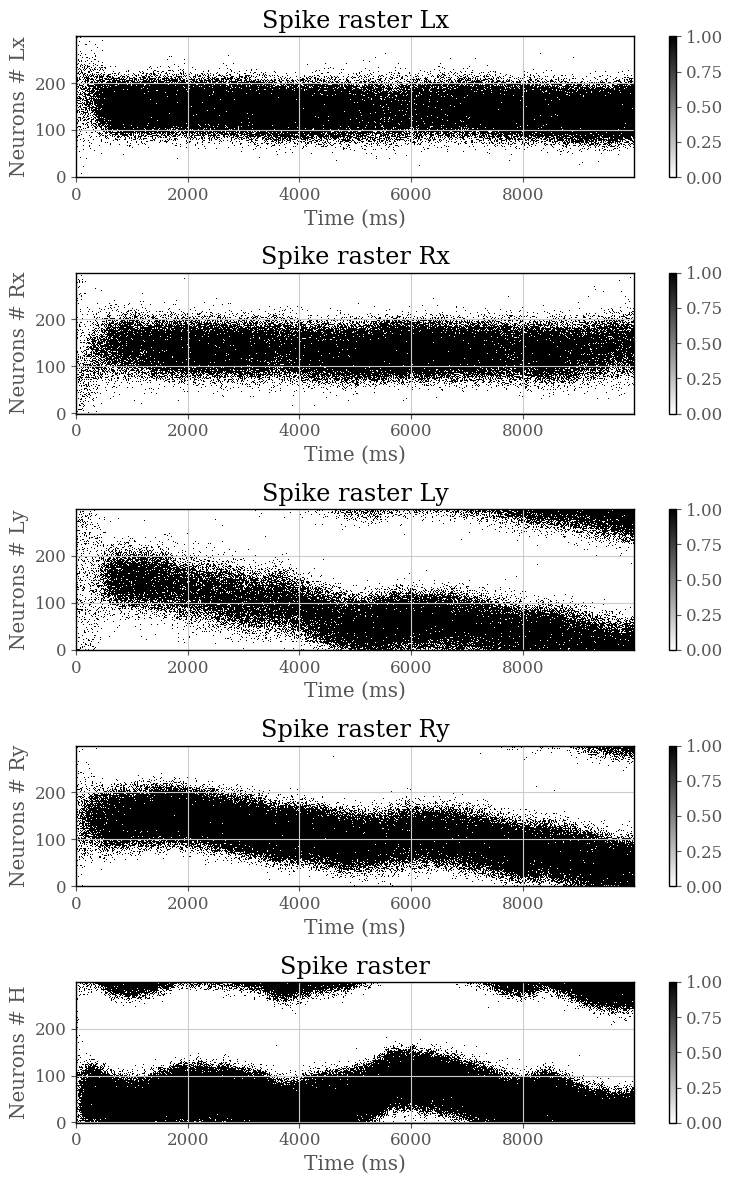

In [178]:
figure = plt.figure(figsize=(8, 12))
plt.subplot(511)
plt.imshow(spikes_lx, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Neurons # Lx')
plt.title('Spike raster Lx')
plt.subplot(512)
plt.imshow(spikes_rx, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Neurons # Rx')
plt.title('Spike raster Rx')

plt.subplot(513)
plt.imshow(spikes_ly, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Neurons # Ly')
plt.title('Spike raster Ly')
plt.subplot(514)
plt.imshow(spikes_ry, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Neurons # Ry')
plt.title('Spike raster Ry')

plt.subplot(515)
plt.imshow(spikes_h, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Neurons # H')
plt.title('Spike raster')

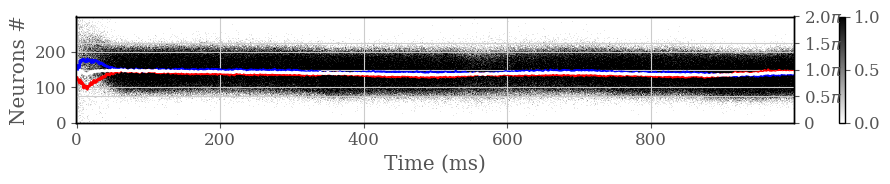

In [179]:
# X
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
mean_rate_lx = calculate_mean_rate(N, T, dt, spikes_lx)
mean_over_time_lx = np.mean(mean_rate_lx, axis=1)

mean_rate_rx = calculate_mean_rate(N, T, dt, spikes_rx)
mean_over_time_rx = np.mean(mean_rate_rx, axis=1)

im = ax.imshow(mean_rate_lx, aspect='auto', origin='lower')
ax.set_ylabel('Neurons #')
ax.set_xlabel('Time (ms)')
plt.colorbar(im)
max_neuron_rate_lx = []
max_neuron_rate_rx = []
for t in range(0, T):
    # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    # if np.sum(mean_rate_lx[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_lx[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    top_neurons = np.argpartition(mean_rate_lx[:, t], -100)[-100:]
    max_neuron_rate_lx.append(np.mean(top_neurons))
    # else:
        # max_neuron_rate_lx.append(np.nan)
        
    # if np.sum(mean_rate_rx[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_rx[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    top_neurons = np.argpartition(mean_rate_rx[:, t], -100)[-100:]
    max_neuron_rate_rx.append(np.mean(top_neurons))
    # else:
        # max_neuron_rate_lx.append(np.nan)

max_neuron_rate_lx = np.array(max_neuron_rate_lx)
max_neuron_rate_rx = np.array(max_neuron_rate_rx)
ax1 = ax.twinx()
max_angle_lx = map_to_degree(max_neuron_rate_lx, N)
max_angle_rx = map_to_degree(max_neuron_rate_rx, N)

ax1.plot(max_angle_lx, color='blue')
ax1.plot(max_angle_rx, color='red')
ax1.plot((max_angle_rx+max_angle_lx)/2, color='white')
# ax1.plot(np.arange(0,T,dt),theta_H - np.mean(theta_H) + 2, 'r')
# ax1.set_ylim(0, 360)
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 


In [180]:
def resampling(signal):
    # calculating the mean rate of the neurons
    mean_rate = np.zeros(T)
    bin_size = 10
    for t in np.arange(0, int(T/dt), bin_size):
        mean_rate[int(t*dt)] = np.mean(signal[t:t+bin_size])
    return mean_rate

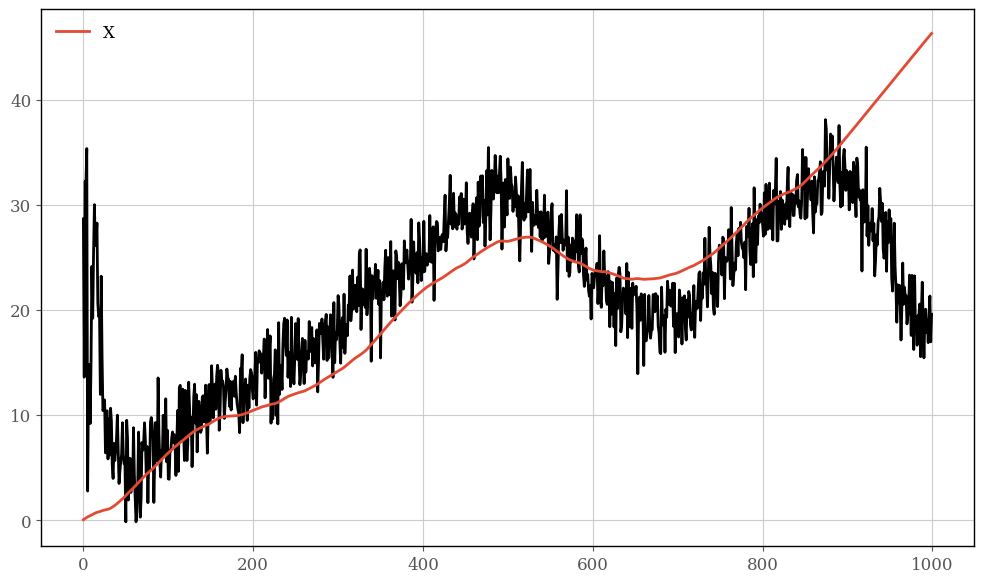

In [181]:
# plt.plot(max_angle_lx, color='blue')
# plt.plot(max_angle_rx, color='red')
mean_bump_x = (max_angle_lx + max_angle_rx) / 2
x_positon_resampled = resampling(position[:, 0])
x_fit = np.polyfit(mean_bump_x, x_positon_resampled, 1)
plt.plot(x_fit[0] * mean_bump_x + x_fit[1], color='k')
plt.plot(x_positon_resampled, label='X')
plt.legend()

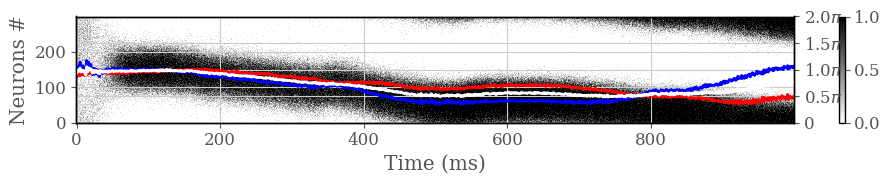

In [182]:
# Y
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
mean_rate_ly = calculate_mean_rate(N, T, dt, spikes_ly)
mean_over_time_ly = np.mean(mean_rate_ly, axis=1)

mean_rate_ry = calculate_mean_rate(N, T, dt, spikes_ry)
mean_over_time_ry = np.mean(mean_rate_ry, axis=1)

im = ax.imshow(mean_rate_ly, aspect='auto', origin='lower')
ax.set_ylabel('Neurons #')
ax.set_xlabel('Time (ms)')
plt.colorbar(im)
max_neuron_rate_ly = []
max_neuron_rate_ry = []
for t in range(0, T):
    # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    # if np.sum(mean_rate_ly[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_ly[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    top_neurons = np.argpartition(mean_rate_ly[:, t], -100)[-100:]
    max_neuron_rate_ly.append(np.mean(top_neurons))
    # else:
        # max_neuron_rate_ly.append(np.nan)
        
    # if np.sum(mean_rate_ry[:, t], axis=0) < 2*N/3 and np.sum(mean_rate_ry[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(mean_rate[:, t]))
    top_neurons = np.argpartition(mean_rate_ry[:, t], -100)[-100:]
    max_neuron_rate_ry.append(np.mean(top_neurons))
    # else:
        # max_neuron_rate_ly.append(np.nan)

max_neuron_rate_ly = np.array(max_neuron_rate_ly)
max_neuron_rate_ry = np.array(max_neuron_rate_ry)
ax1 = ax.twinx()
max_angle_ly = map_to_degree(max_neuron_rate_ly, N)
max_angle_ry = map_to_degree(max_neuron_rate_ry, N)

ax1.plot(max_angle_ly, color='blue')
ax1.plot(max_angle_ry, color='red')
ax1.plot((max_angle_ry+max_angle_ly)/2, color='white')
# ax1.plot(np.arange(0,T,dt),theta_H - np.mean(theta_H) + 2, 'r')
# ax1.set_ylim(0, 360)
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 


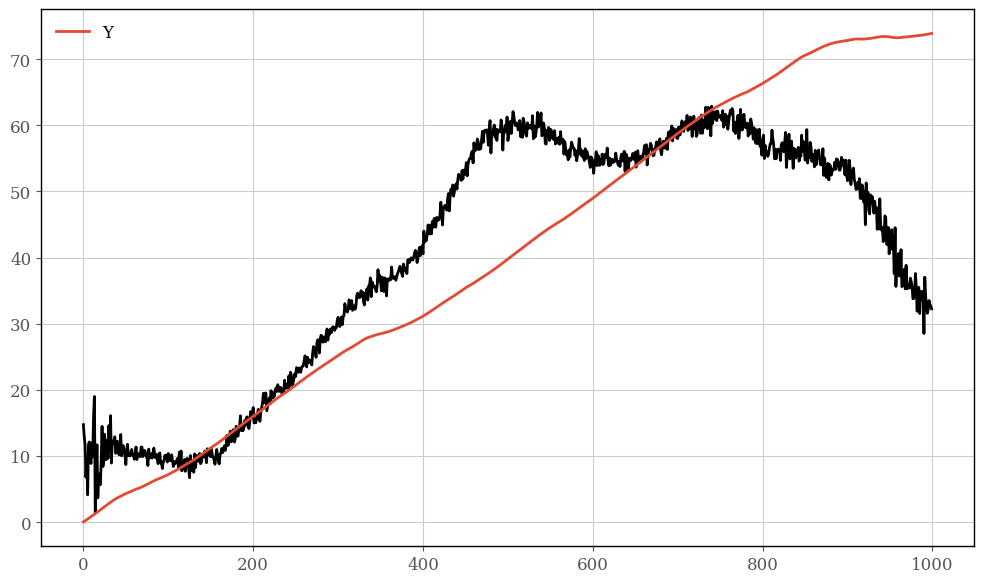

In [183]:
# plt.plot(max_angle_lx, color='blue')
# plt.plot(max_angle_rx, color='red')
mean_bump_y = (max_angle_ly + max_angle_ry) / 2
y_positon_resampled = resampling(position[:, 1])
y_fit = np.polyfit(mean_bump_y, y_positon_resampled, 1)
plt.plot(y_fit[0] * mean_bump_y + y_fit[1], color='k')
plt.plot(y_positon_resampled, label='Y')
plt.legend()

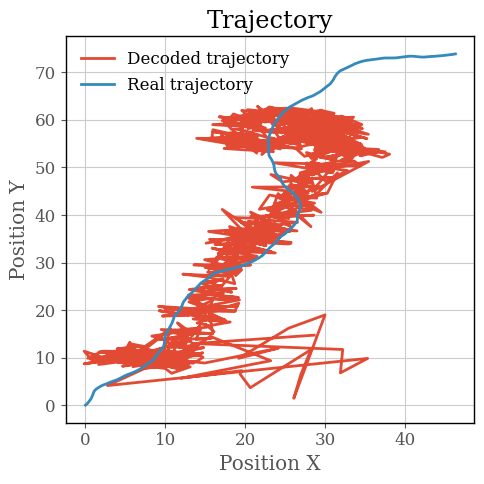

In [189]:
estimated_x = x_fit[0] * mean_bump_x + x_fit[1]
estimated_y = y_fit[0] * mean_bump_y + y_fit[1]
plt.figure(figsize=(5, 5))

plt.plot(estimated_x, estimated_y, label='Decoded trajectory')
plt.plot(position[:, 0], position[:, 1], label='Real trajectory')
plt.title('Trajectory')
plt.ylabel('Position Y')
plt.xlabel('Position X')
plt.legend()
plt.savefig('figures/3.5.pdf')

In [250]:

def simulation(T=1000, dt=0.1, N=300, Jl=3, Jr=3, Jh=5, Jhead=0.5, I0=1, theta_H=None, estimated_H=None, dhdt=None, transfer=None):
    # Check if the necessary functions are provided
    if dhdt is None or transfer is None:
        raise ValueError("dhdt and transfer functions must be provided")
    if len(theta_H) != int(T/dt):
        raise ValueError("theta_H must have the same length as T/dt")
    
    tau = 10 # ms
    R = 1 # Ohm # needs to be asked on the units
    r0 = 10 # mHz
    alpha = 2 # mV^-1
    beta = .5 # mV

    # parameters for the left and right populations
    Xlx = np.linspace(0, 2 * np.pi, N)
    Xrx = np.linspace(0, 2 * np.pi, N)
    Xly = np.linspace(0, 2 * np.pi, N)
    Xry = np.linspace(0, 2 * np.pi, N)
    Xh = np.linspace(0, 2 * np.pi, N)

    theta_lx = 10 * np.pi / 180
    theta_rx = 10 * np.pi / 180
    theta_ly = 10 * np.pi / 180
    theta_ry = 10 * np.pi / 180

    Ilx = np.zeros((N, int(T/dt)))
    Irx = np.zeros((N, int(T/dt)))
    Ily = np.zeros((N, int(T/dt)))
    Iry = np.zeros((N, int(T/dt)))
    Ih = np.zeros((N, int(T/dt)))

    hlx = np.random.uniform(0, 1, (N, int(T/dt)))
    hrx = np.random.uniform(0, 1, (N, int(T/dt)))
    hly = np.random.uniform(0, 1, (N, int(T/dt)))
    hry = np.random.uniform(0, 1, (N, int(T/dt)))
    hh = np.random.uniform(0, 1, (N, int(T/dt)))


    spikes_lx = np.zeros((N, int(T/dt)))
    spikes_rx = np.zeros((N, int(T/dt)))
    spikes_ly = np.zeros((N, int(T/dt)))
    spikes_ry = np.zeros((N, int(T/dt)))

    spikes_h = np.zeros((N, int(T/dt)))

    rate_lx = np.zeros((N, int(T/dt)))
    rate_rx = np.zeros((N, int(T/dt)))
    rate_ly = np.zeros((N, int(T/dt)))
    rate_ry = np.zeros((N, int(T/dt)))

    rate_h = np.zeros((N, int(T/dt)))

    m_cos_lx = 0
    m_cos_rx = 0
    m_cos_ly = 0
    m_cos_ry = 0

    m_cos_h = 0

    m_sin_lx = 0
    m_sin_rx = 0
    m_sin_ly = 0
    m_sin_ry = 0

    m_sin_h = 0

    Jl = 3
    Jr = 3

    Jh = 5
    Jhead = 0.5

    # initial conditions for h such that the center of the bump remains around pi
    # creating initial values for the neurons such that the centering neuron has the highest rate
    peak_index = 150
    std_dev = 50
    indices = np.arange(N)
    normal_dist = np.exp(-((indices - peak_index) ** 2) / (2 * std_dev ** 2))
    initial_array = normal_dist * np.random.normal(0, .3, N)
    initial_array = np.abs(initial_array)

    hlx[:, 0] = initial_array
    hrx[:, 0] = initial_array
    hly[:, 0] = initial_array
    hry[:, 0] = initial_array
    hh[:, 0] = initial_array

    I0 = 1

    # simulation of both populations
    for t in range(0, int(T/dt)):
        # Update values
        Ih[:, t] = Jh * (np.cos(Xh) * m_cos_h + np.sin(Xh) * m_sin_h)
    
        Ilx[:, t] = Jl * (np.cos(Xlx+theta_lx) * m_cos_lx + np.sin(Xlx+theta_lx) * m_sin_lx) + Jr * (np.cos(Xlx+theta_lx) * m_cos_rx + np.sin(Xlx+theta_lx) * m_sin_rx)
        Irx[:, t] = Jr * (np.cos(Xrx-theta_rx) * m_cos_rx + np.sin(Xrx-theta_rx) * m_sin_rx) + Jl * (np.cos(Xrx-theta_rx) * m_cos_lx + np.sin(Xrx-theta_rx) * m_sin_lx)
        
        Ily[:, t] = Jl * (np.cos(Xly+theta_ly) * m_cos_ly + np.sin(Xly+theta_ly) * m_sin_ly) + Jr * (np.cos(Xly+theta_ly) * m_cos_ry + np.sin(Xly+theta_ly) * m_sin_ry)
        Iry[:, t] = Jr * (np.cos(Xry-theta_ry) * m_cos_ry + np.sin(Xry-theta_ry) * m_sin_ry) + Jl * (np.cos(Xry-theta_ry) * m_cos_ly + np.sin(Xry-theta_ry) * m_sin_ly)
        
        I_ext[:, t] = I0 * np.cos(Xh - theta_H[t])
        Ih[:, t] = Ih[:, t] + I_ext[:, t]
        
        Ilx[:, t] = Ilx[:, t] - Jhead * np.cos(Xh - estimated_H[t])
        Irx[:, t] = Irx[:, t] + Jhead * np.cos(Xh - estimated_H[t])

        Ily[:, t] = Ily[:, t] - Jhead * np.sin(Xh - estimated_H[t])
        Iry[:, t] = Iry[:, t] + Jhead * np.sin(Xh - estimated_H[t])


        hh[:, t] = hh[:, t-1] + dt * dhdt(hh[:, t-1], Ih[:, t-1], tau, R)
        
        hlx[:, t] = hlx[:, t-1] + dt * dhdt(hlx[:, t-1], Ilx[:, t-1], tau, R)
        hrx[:, t] = hrx[:, t-1] + dt * dhdt(hrx[:, t-1], Irx[:, t-1], tau, R)
        
        hly[:, t] = hly[:, t-1] + dt * dhdt(hly[:, t-1], Ily[:, t-1], tau, R)
        hry[:, t] = hry[:, t-1] + dt * dhdt(hry[:, t-1], Iry[:, t-1], tau, R)
        
        rate_h[:, t] = r0 * transfer(hh[:, t], alpha, beta)
        
        rate_lx[:, t] = r0 * transfer(hlx[:, t], alpha, beta)
        rate_rx[:, t] = r0 * transfer(hrx[:, t], alpha, beta)
        
        rate_ly[:, t] = r0 * transfer(hly[:, t], alpha, beta)
        rate_ry[:, t] = r0 * transfer(hry[:, t], alpha, beta)
        
        spikes_h[:, t] = np.random.binomial(1, rate_h[:, t] * dt)
        spikes_lx[:, t] = np.random.binomial(1, rate_lx[:, t] * dt)
        spikes_rx[:, t] = np.random.binomial(1, rate_rx[:, t] * dt)
        
        spikes_ly[:, t] = np.random.binomial(1, rate_ly[:, t] * dt)
        spikes_ry[:, t] = np.random.binomial(1, rate_ry[:, t] * dt)
        
        m_cos_h = np.mean(np.cos(Xh) * spikes_h[:, t])
        m_sin_h = np.mean(np.sin(Xh) * spikes_h[:, t])
        
        m_cos_lx = np.mean(np.cos(Xlx) * spikes_lx[:, t])
        m_cos_rx = np.mean(np.cos(Xrx) * spikes_rx[:, t])
        
        m_cos_ly = np.mean(np.cos(Xly) * spikes_ly[:, t])
        m_cos_ry = np.mean(np.cos(Xry) * spikes_ry[:, t])
        
        m_sin_lx = np.mean(np.sin(Xlx) * spikes_lx[:, t])
        m_sin_rx = np.mean(np.sin(Xrx) * spikes_rx[:, t])

        m_sin_ly = np.mean(np.sin(Xly) * spikes_ly[:, t])
        m_sin_ry = np.mean(np.sin(Xry) * spikes_ry[:, t])

    return [spikes_lx, spikes_rx, spikes_ly, spikes_ry, spikes_h]

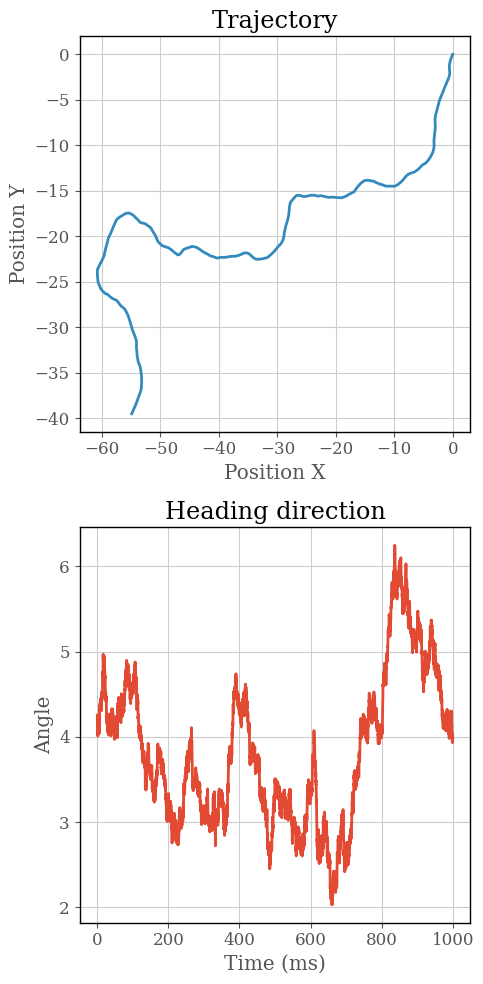

In [293]:
np.random.seed(51)
theta_H, position = generate_trajectory(T = 1000, dt = .1, speed = .1, std_dev = .03)
plt.figure(figsize=(5, 10))
plt.subplot(211)
plt.plot(position[0, 0], position[0, 1])
plt.plot(position[:, 0], position[:, 1])
plt.title('Trajectory')
plt.ylabel('Position Y')
plt.xlabel('Position X')
plt.subplot(212)
plt.title('Heading direction')
plt.plot(np.arange(0, 1000, 0.1), theta_H)
plt.ylabel('Angle')
plt.xlabel('Time (ms)')
plt.tight_layout()

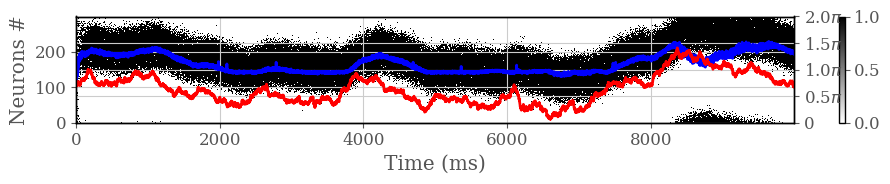

In [294]:
T = 1000 # ms
dt = .1 # ms
N = 300
X = np.linspace(0, 2 * np.pi, N)
I = np.zeros((N, int(T/dt)))
h = np.random.uniform(0, 1, (N, int(T/dt)))
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV
# h = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))
rate = np.zeros((N, int(T/dt)))
I_ext = np.zeros((N, int(T/dt)))
I0 = 1
m_cos = 0
m_sin = 0
J = 5
# spikes = np.random.binomial(1, np.ones(N) * dt, (N, int(T/dt)))
# h = np.random.normal(0, 1, (N, int(T/dt)))
for t in range(0, int(T/dt)):
    I[:, t] = J * (np.cos(X) * m_cos + np.sin(X) * m_sin)
    I_ext[:, t] = I0 * np.cos(X - theta_H[t])
    I[:, t] = I[:, t] + I_ext[:, t]
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    m_cos = np.mean(np.cos(X) * spikes[:, t])
    m_sin = np.mean(np.sin(X) * spikes[:, t])

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
# mean_rate = calculate_mean_rate(N, T, dt, spikes)
mean_over_time = np.mean(spikes, axis=1)
im = ax.imshow(spikes, aspect='auto', origin='lower')
ax.set_ylabel('Neurons #')
ax.set_xlabel('Time (ms)')
plt.colorbar(im)
max_neuron_rate = []
for t in range(0, int(T/dt)):
    # max_neuron_rate.append(np.argmax(spikes[:, t]))
    if np.sum(spikes[:, t], axis=0) < 2*N/3 and np.sum(spikes[:, t], axis=0) > N/3:
        # max_neuron_rate.append(np.argmax(spikes[:, t]))
        top_neurons = np.argpartition(spikes[:, t], -100)[-100:]
        max_neuron_rate.append(np.mean(top_neurons))
    else:
        max_neuron_rate.append(np.nan)
# mean_over_neurons = np.mean(mean_rate, axis=0)
# plt.plot(max_neuron_rate, color='white')
ax1 = ax.twinx()
max_neuron_rate = np.array(max_neuron_rate)
max_angle = map_to_degree(max_neuron_rate, N)

ax1.plot(max_angle, color='blue')
# ax1.plot(estimated_h, color='white')
ax1.plot(theta_H - np.mean(theta_H) + 2, 'r')
# ax1.set_ylim(0, 360)
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 



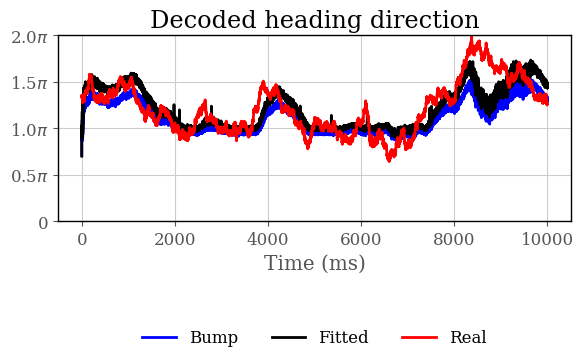

In [306]:
# Decoding the heading direction
# mask = np.isfinite(max_angle) & np.isfinite(theta_H)
# max_angle = max_angle[mask]
# theta_H = theta_H[mask]
h_fit = np.polyfit(max_angle, theta_H, 1)
estimated_h = h_fit[0] * max_angle + h_fit[1]

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.plot(max_angle, color='blue', label='Bump')
ax1.plot(estimated_h, color='k', label='Fitted')
ax1.plot(theta_H, 'r', label='Real')
# ax1.set_ylim(0, 360)
ax1.set_ylim(0, 2 * np.pi)
ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}$\pi$'.format(y/np.pi) if y !=0 else '0')) 
ax1.title.set_text('Decoded heading direction')
plt.xlabel('Time (ms)')
# location of the legend outside the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -.5), shadow=True, ncol=3)
plt.savefig('figures/3.3.0.pdf')

In [314]:
trial = 20
estimated_x_holder = np.zeros((trial, int(T/dt)))
estimated_y_holder = np.zeros((trial, int(T/dt)))

for i in range(trial):
    [spikes_lx, spikes_rx, spikes_ly, spikes_ry, spikes_h] = simulation(T=1000, dt=0.1, N=300, Jl=3, Jr=3, Jh=5, Jhead=1, I0=1, theta_H=theta_H, estimated_H=max_angle, dhdt=dhdt, transfer=transfer)

    # Preallocate arrays
    max_neuron_rate_lx = np.zeros(int(T/dt))
    max_neuron_rate_rx = np.zeros(int(T/dt))
    max_neuron_rate_ly = np.zeros(int(T/dt))
    max_neuron_rate_ry = np.zeros(int(T/dt))

    for t in range(int(T/dt)):
        # Use argpartition to find the top 100 neurons
        top_neurons_lx = np.argpartition(spikes_lx[:, t], -100)[-100:]
        top_neurons_rx = np.argpartition(spikes_rx[:, t], -100)[-100:]
        top_neurons_ly = np.argpartition(spikes_ly[:, t], -100)[-100:]
        top_neurons_ry = np.argpartition(spikes_ry[:, t], -100)[-100:]

        # Calculate the mean rate of the top neurons
        max_neuron_rate_lx[t] = np.mean(top_neurons_lx)
        max_neuron_rate_rx[t] = np.mean(top_neurons_rx)
        max_neuron_rate_ly[t] = np.mean(top_neurons_ly)
        max_neuron_rate_ry[t] = np.mean(top_neurons_ry)

    # Map to degrees
    max_angle_lx = map_to_degree(max_neuron_rate_lx, N)
    max_angle_rx = map_to_degree(max_neuron_rate_rx, N)
    max_angle_ly = map_to_degree(max_neuron_rate_ly, N)
    max_angle_ry = map_to_degree(max_neuron_rate_ry, N)

    # Calculate mean angles
    mean_angle_x = (max_angle_lx + max_angle_rx) / 2
    mean_angle_y = (max_angle_ly + max_angle_ry) / 2

    # Fit a line to the data
    x_fit = np.polyfit(mean_angle_x, position[:, 0], 1)
    y_fit = np.polyfit(mean_angle_y, position[:, 1], 1)

    # Calculate estimated positions
    estimated_x = x_fit[0] * mean_angle_x + x_fit[1]
    estimated_y = y_fit[0] * mean_angle_y + y_fit[1]
    # shifting the estimated values such that it starts from (0, 0)
    estimated_x_holder[i] = estimated_x - estimated_x[0]
    estimated_y_holder[i] = estimated_y - estimated_y[0]

In [315]:
mean_x = np.mean(estimated_x_holder, axis=0)
std_x = np.std(estimated_x_holder, axis=0)
mean_y = np.mean(estimated_y_holder, axis=0)
std_y = np.std(estimated_y_holder, axis=0)

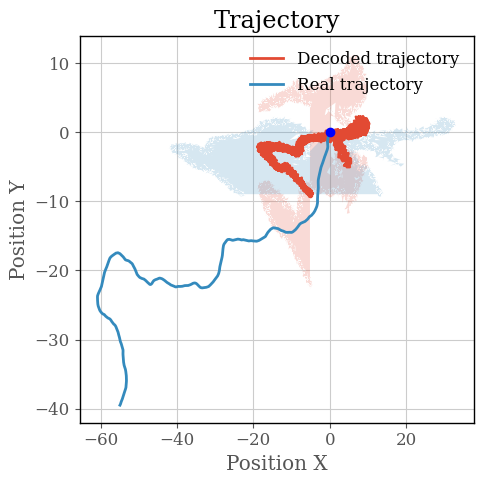

In [316]:
plt.figure(figsize=(5, 5))
plt.plot(mean_x, mean_y, label='Decoded trajectory')
plt.fill_between(mean_x, mean_y - std_y, mean_y + std_y, alpha=0.2)
plt.fill_betweenx(mean_y, mean_x - std_x, mean_x + std_x, alpha=0.2)
plt.plot(position[:, 0], position[:, 1], label='Real trajectory')
plt.plot(position[0, 0], position[0, 1], 'bo')
plt.title('Trajectory')
plt.ylabel('Position Y')
plt.xlabel('Position X')
plt.legend()
plt.savefig('figures/3.5.pdf')

In [312]:
estimated_x_holder[:, 0]

array([-22.93306428, -22.13017246, -35.34261945,  20.96174956,
       -41.9356188 , -22.93091135, -33.63305053,  27.05128581,
       -42.95914564, -43.55382641, -21.69400887, -28.81843324,
       -21.30822974, -15.63227935, -38.06901294,  32.40863065,
       -34.49427101, -10.21868159, -15.34101577, -13.6784509 ])